In [ ]:
import pandas as pd
import gym
from gym import spaces
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
import os
from tqdm import tqdm
import logging
import matplotlib.pyplot as plt
from google.colab import files
from google.colab import drive


!pip install gym
!pip install openpyxl



drive.mount('/content/drive')


def load_excel_data():
    uploaded = files.upload()  # This prompts for file upload
    file_name = list(uploaded.keys())[0]
    df = pd.read_excel(file_name)
    df = df.replace(',', '.', regex=True)  # Replace commas with periods
    for col in ['open', 'high', 'low', 'close', 'volume', 'rsi', 'bbw', 'lrc', 'adc', 'adx']:
        df[col] = pd.to_numeric(df[col], errors='coerce')  # Convert to numeric
    df = df.sort_values('original_timestamp').reset_index(drop=True)
    print(f"Loaded data with {len(df)} rows.")
    return df


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


# Setup logging
log_dir = "/content/drive/My Drive/Trading_vrm/logs"
os.makedirs(log_dir, exist_ok=True)
log_file = os.path.join(log_dir, "training_logs2_vrm.txt")
logging.basicConfig(
    filename=log_file,
    level=logging.INFO,
    format="%(asctime)s - %(message)s",
    filemode="w"
)

logger = logging.getLogger("training_logger")

# Validation logging setup
validation_log_file = os.path.join(log_dir, "validation_logs.txt")
validation_handler = logging.FileHandler(validation_log_file, mode="w")
validation_handler.setLevel(logging.INFO)
validation_handler.setFormatter(logging.Formatter("%(asctime)s - %(message)s"))

validation_logger = logging.getLogger("validation_logger")
validation_logger.setLevel(logging.INFO)
validation_logger.addHandler(validation_handler)


def create_rl_dataset(df):
    df['returns'] = df['close'].pct_change()
    df['reward'] = (df['returns'] * 100).shift(-1)  # Used only for evaluation
    return df.dropna()  # Drop rows with NaN values




def clip_rewards(values, min_value=-10, max_value=10):
    return np.clip(values, min_value, max_value)

def normalize_data(df):
    # List of columns to normalize
    columns_to_normalize = ['close', 'rsi', 'bbw', 'lrc', 'adc', 'reward']  # Include 'reward'

    # Normalize the columns
    for col in columns_to_normalize:
        if col in df.columns:
            df[col] = (df[col] - df[col].mean()) / df[col].std()  # Standardization

    # Apply clipping to specific columns after normalization
    if 'bbw' in df.columns:
        logger.info(f"Original BBW stats: {df['bbw'].describe()}")
        df['bbw'] = clip_rewards(df['bbw'], min_value=-10, max_value=10)
        logger.info(f"Clipped BBW stats: {df['bbw'].describe()}")

    if 'reward' in df.columns:
        logger.info(f"Normalized Reward stats: {df['reward'].describe()}")
        df['reward'] = clip_rewards(df['reward'], min_value=-15, max_value=15)
        logger.info(f"Clipped Reward stats: {df['reward'].describe()}")

    return df


def save_metrics_to_excel(metrics, file_name):

    new_data = pd.DataFrame(metrics if isinstance(metrics, list) else [metrics])
    if os.path.exists(file_name):
        existing_data = pd.read_excel(file_name)
        updated_data = pd.concat([existing_data, new_data], ignore_index=True)
    else:
        updated_data = new_data
    updated_data.to_excel(file_name, index=False)
    logger.info(f"Metrics saved to {file_name}")




def plot_loss_with_indices(step_losses, original_indices, episode):
    plots_dir = "/content/drive/My Drive/Trading_vrm/plots_vrm1"
    os.makedirs(plots_dir, exist_ok=True)

    plt.figure(figsize=(12, 6))
    plt.plot(original_indices, step_losses, label=f"Episode {episode} Loss")
    plt.xlabel("Original Data Index")
    plt.ylabel("Loss")
    plt.title(f"Loss Curve for Episode {episode}")
    plt.legend()
    plt.grid(True)

    # Save the plot
    plot_filename = os.path.join(plots_dir, f"loss_episode_{episode}.png")
    plt.savefig(plot_filename)
    plt.close()
    print(f"Saved loss plot for Episode {episode} to {plot_filename}")


def log_and_save_metrics(metrics, filename, logger, title="", portfolio_values=None):
    """
    Logs metrics to the logger and saves them to an Excel file.

    Args:
        metrics (dict): The metrics to log and save.
        filename (str): Path to the Excel file.
        logger (logging.Logger): Logger to log metrics.
        title (str): Title to log.
        portfolio_values (list): Optional list of portfolio values to save.
    """
    if title:
        logger.info(title)
    logger.info(metrics)

    # Create a DataFrame for metrics
    metrics_df = pd.DataFrame([metrics])

    # Add portfolio values as a separate column (optional)
    if portfolio_values:
        metrics_df["Portfolio Values"] = [portfolio_values]  # Save as a single column

    # Append or create Excel file
    if os.path.exists(filename):
        existing_data = pd.read_excel(filename)
        updated_data = pd.concat([existing_data, metrics_df], ignore_index=True)
    else:
        updated_data = metrics_df

    updated_data.to_excel(filename, index=False)
    logger.info(f"Metrics saved to {filename}")



def evaluate(env, model, data, gamma=0.99):
    rewards_m = []
    portfolio_values = []
    negative_returns = []
    evaluation_step_losses = []  # Track losses during evaluation
    profits_v = []
    trade_durations = []  # Collect trade durations from the environment

    model.eval()  # Set model to evaluation mode
    validation_logger.info(f"Model is in evaluation mode: {not model.training}")

    try:
        state = env._next_observation()  # Fetch the current observation (filtered to selected features)
        validation_logger.info(f"Initial state shape during evaluation: {state.shape}")

        for step in range(len(data) - env.current_step):  # Continue from the current step
            # Convert the state to a tensor
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)

            # Validate that the state has the correct shape
            expected_feature_count = env.observation_space.shape[0]
            if state_tensor.shape[1] != expected_feature_count:
                raise ValueError(
                    f"State feature mismatch: Expected {expected_feature_count}, got {state_tensor.shape[1]}"
                )

            # Perform inference and get Q-values
            with torch.no_grad():
                q_values = model(state_tensor)
                action = torch.argmax(q_values).item()

            # Take an action in the environment
            next_state, reward, done, info = env.step(action)

            # Verify shape of next_state
            if len(next_state) != expected_feature_count:
                raise ValueError(
                    f"Next state feature mismatch: Expected {expected_feature_count}, got {len(next_state)}"
                )

            # Calculate evaluation loss
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
            if state_tensor.shape[1] != len(['close', 'rsi', 'bbw', 'lrc', 'adx']):
                raise ValueError(
                    f"State shape mismatch: Expected {len(['close', 'rsi', 'bbw', 'lrc', 'adx'])}, got {state_tensor.shape[1]}"
                )
            with torch.no_grad():
                next_state_tensor = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0).to(device)
                next_q_values = model(next_state_tensor)
                max_next_q_value = (
                    next_q_values.max(1)[0].item() if len(next_q_values.shape) > 1 else next_q_values.max().item()
                ) if not done else 0

                # Define target Q-value
                target_q_value = reward + gamma * max_next_q_value

            predicted_q_value = (
                q_values[0, action] if len(q_values.shape) > 1 else q_values[action]
            )
            evaluation_loss = (predicted_q_value - target_q_value) ** 2
            evaluation_step_losses.append(evaluation_loss.item())
            profits_v.append(info.get("profit", 0))

            # Collect trade durations from info
            trade_durations.extend(info.get("trade_durations", []))

            # Log results
            validation_logger.debug(f"Step {step}: Q-Values: {q_values.cpu().numpy()}, Selected Action: {action}")
            validation_logger.debug(
                f"Step {step}: Action Taken: {action}, Reward: {reward}, "
                f"Balance: {info['balance']}, Position: {info['position']}, "
                f"Portfolio Value: {info['portfolio_value']}"
            )

            # Append metrics for analysis
            rewards_m.append(reward)
            portfolio_values.append(info["portfolio_value"])
            if reward < 0:
                negative_returns.append(reward)

            # Move to the next state
            state = next_state
            if done:
                validation_logger.debug(f"Step {step}: Evaluation Complete")
                break

        # After the loop, calculate avg_loss and log it
        avg_loss = np.mean(evaluation_step_losses) if evaluation_step_losses else 0
        validation_logger.info(f"Final Evaluation Average Loss: {avg_loss:.6f}")

        realized_profits_v = [p for p in profits_v if p != 0]
        returns_v = [
            profits_v / env.initial_balance
            for profits_v in realized_profits_v
            if env.initial_balance > 0
        ]

        # Calculate average trade duration
        avg_trade_duration = np.mean(trade_durations) if trade_durations else 0

        # Calculate evaluation metrics
        return {
            "Total Reward": sum(rewards_m),
            "Average Trade Return": np.mean(rewards_m) if rewards_m else 0,
            "Win Rate": env.successful_trades / env.total_trades if env.total_trades > 0 else 0,
            "Total Trades": env.total_trades,
            "Successful Trades": env.successful_trades,
            "Profit Factor": (
                sum(r for r in realized_profits_v if r > 0) /
                abs(sum(r for r in realized_profits_v if r < 0)) if realized_profits_v else float('inf')
            ),
            "Sharpe Ratio": (
                (np.mean(returns_v) / (np.std(returns_v) + 1e-8))
                if len(returns_v) > 1 else 0
            ),
            "Sortino Ratio": (
                (np.mean(returns_v) / (np.std(negative_returns) + 1e-8)) * np.sqrt(252)
                if len(negative_returns) > 0 else 0
            ),
            "Maximum Drawdown": np.max(
                (np.maximum.accumulate(np.array(portfolio_values)) - np.array(portfolio_values))
                / np.maximum.accumulate(np.array(portfolio_values))
            ) if portfolio_values else 0,
            "Average Loss": avg_loss,
            "Final Balance": env.balance,
            "Average Trade Duration": avg_trade_duration,  # New metric
        }
    except Exception as e:
        validation_logger.error(f"Evaluation failed: {e}")
        return {
            "Total Reward": 0,
            "Average Trade Return": 0,
            "Win Rate": 0,
            "Total Trades": 0,
            "Successful Trades": 0,
            "Profit Factor": 0,
            "Sharpe Ratio": 0,
            "Sortino Ratio": 0,
            "Maximum Drawdown": 0,
            "Average Loss": None,
            "Final Balance": env.initial_balance,
            "Average Trade Duration": 0,  # New metric in case of failure
        }
    finally:
        model.train()



        # Calculate evaluation metrics
        total_reward = sum(rewards_m)
        avg_trade_return = np.mean(returns_v) if returns_v else 0

        total_trades = env.total_trades  # Use current metrics from the environment
        successful_trades = env.successful_trades
        win_rate = successful_trades / total_trades if total_trades > 0 else 0

        gross_profit = sum(r for r in returns_v if r > 0)
        gross_loss = abs(sum(r for r in returns_v if r < 0))
        profit_factor = gross_profit / gross_loss if gross_loss > 0 else float("inf")

        sharpe_ratio = (
            np.mean(returns_v) / (np.std(returns_v) + 1e-8)
            if len(returns_v) > 1 else 0
        )


        downside_std = np.std(negative_returns) if negative_returns else 0
        sortino_ratio = (
            (np.mean(returns_v) / (downside_std + 1e-8)) * np.sqrt(252)
            if len(negative_returns) > 0 else 0
        )

        portfolio_array = np.array(portfolio_values)
        peaks = np.maximum.accumulate(portfolio_array)
        drawdowns = (peaks - portfolio_array) / peaks
        max_drawdown = np.max(drawdowns) if len(drawdowns) > 0 else 0

        # Calculate average loss per episode if step_losses are provided

        # Get the final balance from the environment
        final_balance = env.balance

        # Return evaluation metrics
        return {
            "Total Reward": total_reward,
            "Average Trade Return": avg_trade_return,
            "Win Rate": win_rate,
            "Total Trades": total_trades,
            "Successful Trades": successful_trades,
            "Profit Factor": profit_factor,
            "Sharpe Ratio": sharpe_ratio,
            "Sortino Ratio": sortino_ratio,
            "Maximum Drawdown": max_drawdown,
            "Average Loss": avg_loss,  # Include average loss
            "Final Balance": final_balance,  # New metric
        }


def plot_normalized_data(df, columns_to_plot, title="Normalized Data Overview"):
    num_metrics = len(columns_to_plot)
    num_cols = 3
    num_rows = (num_metrics + num_cols - 1) // num_cols

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
    fig.suptitle(title, fontsize=16)
    axes = axes.flatten()

    for i, col in enumerate(columns_to_plot):
        if col in df.columns:
            y = df[col].replace([np.inf, -np.inf], np.nan)  # Replace invalid values with NaN
            axes[i].plot(df.index, y, label=col)
            axes[i].set_title(col)
            axes[i].set_xlabel("Index")
            axes[i].set_ylabel("Values")
            axes[i].legend()
            axes[i].grid(True)
        else:
            axes[i].set_visible(False)

    for i in range(len(columns_to_plot), len(axes)):
        axes[i].set_visible(False)

    plt.tight_layout(rect=[0, 0, 1, 0.96])

    save_dir = "/content/drive/My Drive/Trading_vrm/plots_vrm2"
    os.makedirs(save_dir, exist_ok=True)
    save_path = os.path.join(save_dir, "normalized_data_overview_vrm2.png")
    plt.savefig(save_path)
    plt.show()
    print(f"Saved normalized data plot to {save_path}")



def plot_segments(segments, time_column, value_column, title="Segments Overview"):
    """
    Plots the segments with different colors to visualize the splits.
    Args:
        segments (list): List of DataFrames representing segments.
        time_column (str): The column representing time.
        value_column (str): The column to plot as the y-axis.
        title (str): Title of the plot.
    """
    plt.figure(figsize=(14, 8))

    for i, segment in enumerate(segments):
        plt.plot(segment[time_column], segment[value_column], label=f"Segment {i + 1}")

    plt.xlabel("Time")
    plt.ylabel(value_column.capitalize())
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()



def save_checkpoint(checkpoint_dir, model, optimizer, episode, epsilon):
    os.makedirs(checkpoint_dir, exist_ok=True)
    checkpoint_path = os.path.join(checkpoint_dir, f"checkpoint_episode_{episode}.pth")
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'episode': episode,
        'epsilon': epsilon
    }, checkpoint_path)
    logger.info(f"Checkpoint saved at {checkpoint_path}")


def load_checkpoint(checkpoint_dir, model, optimizer=None):
    checkpoint_files = [f for f in os.listdir(checkpoint_dir) if f.endswith('.pth')]
    if not checkpoint_files:
        logger.info("No checkpoint found. Starting from scratch.")
        return None

    # Find the most recent checkpoint by episode number
    checkpoint_files.sort(key=lambda x: int(x.split('_')[-1].split('.')[0]))
    latest_checkpoint = os.path.join(checkpoint_dir, checkpoint_files[-1])

    checkpoint = torch.load(latest_checkpoint)
    model.load_state_dict(checkpoint['model_state_dict'])
    if optimizer and 'optimizer_state_dict' in checkpoint:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    episode = checkpoint.get('episode', 0)
    epsilon = checkpoint.get('epsilon', 1.0)

    logger.info(f"Loaded checkpoint from {latest_checkpoint}")
    return episode, epsilon


def split_data_by_gaps(df, time_column, gap_threshold):
    """
    Splits the dataset into segments based on gaps in the data.
    Args:
        df (pd.DataFrame): The input dataset.
        time_column (str): The column representing time.
        gap_threshold (int or float): The threshold for detecting gaps (e.g., in seconds).
    Returns:
        list: A list of DataFrames, each representing a contiguous segment.
    """
    df = df.sort_values(by=time_column).reset_index(drop=True)
    time_deltas = df[time_column].diff().fillna(0)
    split_indices = time_deltas[time_deltas > gap_threshold].index
    segments = []

    # Create segments by splitting at gap indices
    prev_idx = 0
    for idx in split_indices:
        segments.append(df.iloc[prev_idx:idx].reset_index(drop=True))
        prev_idx = idx
    segments.append(df.iloc[prev_idx:].reset_index(drop=True))  # Last segment

    return segments

def plot_loss(step_losses, episode):

    plots_dir = "plots2"
    os.makedirs(plots_dir, exist_ok=True)

    plt.figure(figsize=(10, 6))
    plt.plot(step_losses, label=f"Episode {episode} Loss")
    plt.xlabel("Steps")
    plt.ylabel("Loss")
    plt.title(f"Loss Curve for Episode {episode}")
    plt.legend()
    plt.grid(True)

    # Save the plot
    plot_filename = os.path.join(plots_dir, f"loss_episode_{episode}.png")
    plt.savefig(plot_filename)
    plt.close()
    print(f"Saved loss plot for Episode {episode} to {plot_filename}")



# --- RL Environment ---

class BTCTradingEnv(gym.Env):
    def __init__(self, df):
        super(BTCTradingEnv, self).__init__()
        self.df = df.reset_index(drop=True)
        self.current_step = 0
        self.action_space = spaces.Discrete(4)  # 0: Hold, 1: Long, 2: Short, 3: Close
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(len(['close', 'rsi', 'bbw', 'lrc', 'adx']),), dtype=np.float32
        )

        self.initial_balance = 100000
        self.balance = self.initial_balance
        self.position = 0  # Current position: 0 = None, 1 = Long, -1 = Short
        self.position_size = 0
        self.position_value = 0
        self.holding_duration = 0
        self.max_holding_duration = 0

        self.trade_duration = 0  # Tracks duration of the current trade
        self.trade_durations = []  # Stores all trade durations

        # Initialize trade metrics
        self.total_trades = 0
        self.successful_trades = 0
        self.sum_rewards = 0  # Total rewards for the episode

    def reset(self):
        """Reset the environment for a new episode."""
        self.current_step = 0
        self.balance = self.initial_balance
        self.position = 0
        self.position_size = 0
        self.position_value = 0
        self.holding_duration = 0
        self.max_holding_duration = 0
        self.trade_duration = 0
        self.trade_durations = []

        # Reset trade metrics
        self.total_trades = 0
        self.successful_trades = 0
        self.sum_rewards = 0

        return self._next_observation()

    def _next_observation(self):
        obs = self.df[['close', 'rsi', 'bbw', 'lrc', 'adx']].iloc[self.current_step].values
        logger.info(f"_next_observation() - Current Step: {self.current_step}, Observation: {obs}")
        return obs

    def step(self, action):
        current_price = self.df.iloc[self.current_step]['close']
        trade_amount = self.initial_balance * 0.05  # 5% of initial balance per trade
        penalty_multiplier = 0  # Multiplier to punish negative trades more severely
        reward = 0.0  # Directly use reward without normalization
        pnl = 0
        profit = 0

        # Handle actions
        if action == 0:  # Hold
            reward += 0.1  # Incentivize holding
            self.holding_duration += 1  # Increment holding duration
            self.max_holding_duration = max(self.max_holding_duration, self.holding_duration)
        else:
            self.holding_duration = 0  # Reset holding duration on any other action

        if action == 1:  # Long
            if self.position == 0:  # Open a new long position
                self.position = 1
                self.position_size = trade_amount / current_price
                self.balance -= trade_amount
                self.position_value = current_price
                self.trade_duration = 1  # Start tracking trade duration
            else:
                reward -= 0.1  # Penalize redundant action
                self.trade_duration += 1  # Increment trade duration if already in a position

        elif action == 2:  # Short
            if self.position == 0:  # Open a new short position
                self.position = -1
                self.position_size = trade_amount / current_price
                self.balance -= trade_amount
                self.position_value = current_price
                self.trade_duration = 1  # Start tracking trade duration
            else:
                reward -= 0.1  # Penalize redundant action
                self.trade_duration += 1  # Increment trade duration if already in a position

        elif action == 3:  # Close Position
            if self.position != 0:  # Only close if a position is open
                pnl = 0
                if self.position == 1:  # Closing a long position
                    pnl = self.position_size * (current_price - self.position_value)
                elif self.position == -1:  # Closing a short position
                    pnl = self.position_size * (self.position_value - current_price)

                self.balance += pnl + trade_amount
                if pnl > 0:
                    reward += pnl * 0.01  # Reward for profitable trades
                    self.successful_trades += 1  # Increment successful trades
                else:
                    reward += pnl * penalty_multiplier  # Penalize negative PnL

                self.total_trades += 1  # Increment total trades
                profit = pnl

                # Log trade duration
                self.trade_durations.append(self.trade_duration)
                self.trade_duration = 0  # Reset trade duration after closing a trade

                # Reset position
                self.position = 0
                self.position_size = 0
                self.position_value = 0
            else:
                reward -= 0.1  # Penalize invalid close action
                profit = 0

        # Accumulate rewards
        self.sum_rewards += reward
        current_portfolio_value = self.balance + (self.position_size * current_price if self.position != 0 else 0)

        # Check if the environment has reached its end
        done = self.current_step >= len(self.df) - 1
        if not done:
            self.current_step += 1

        next_observation = self._next_observation() if not done else np.zeros(self.observation_space.shape)

        # Get feature names for logging (excluding target/reward column)
        feature_names = self.df.columns[:-1]  # Assuming the last column is 'reward'

        # Log the features with their names
        current_features = {feature_names[i]: self.df.iloc[self.current_step, i] for i in range(len(feature_names))}
        logger.info(f"Step {self.current_step}: Current Features: {current_features}")

        return next_observation, reward, done, {
            "balance": self.balance,
            "position": self.position,
            "position_size": self.position_size,
            "portfolio_value": current_portfolio_value,
            "total_trades": self.total_trades,
            "successful_trades": self.successful_trades,
            "sum_rewards": self.sum_rewards,
            "profit": profit,  # Add profit info here
            "holding_duration": self.holding_duration,  # Add holding duration
            "max_holding_duration": self.max_holding_duration,  # Add max holding duration
            "trade_durations": self.trade_durations,  # Add trade durations
        }

# --- DQN Model ---
class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# --- Replay Buffer ---
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        # Ensure state and next_state have consistent shapes
        if next_state is not None and state is not None:
            if state.shape != next_state.shape:
                next_state = np.zeros_like(state, dtype=np.float32)
                logging.warning(f"Inconsistent state shapes detected. Replacing next_state with zeros: {state.shape} != {next_state.shape}")

        self.buffer.append((state, action, reward, next_state, done))


    def sample(self, batch_size):
        samples = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*samples)

        # Convert to arrays with consistent shapes
        states = np.array(states, dtype=np.float32)
        actions = np.array(actions, dtype=np.int64)
        rewards = np.array(rewards, dtype=np.float32)
        next_states = np.array(next_states, dtype=np.float32)
        dones = np.array(dones, dtype=np.float32)

        return states, actions, rewards, next_states, dones


    def __len__(self):
        return len(self.buffer)  # Returns the current size of the buffer



def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)  # Xavier uniform initialization
            if m.bias is not None:
                nn.init.zeros_(m.bias)


def split_data_by_gaps_unix(df, time_column):
    """
    Splits the dataset into segments whenever a gap greater than 5 minutes exists between consecutive Unix timestamps.
    Args:
        df (pd.DataFrame): The input dataset.
        time_column (str): The column representing Unix time in milliseconds.
    Returns:
        list: A list of DataFrames, each representing a contiguous segment.
    """
    # Convert Unix timestamp to seconds and datetime format
    df[time_column] = pd.to_datetime(df[time_column] / 1000, unit='s')
    df = df.sort_values(by=time_column).reset_index(drop=True)

    # Calculate time differences in seconds
    time_deltas = df[time_column].diff().dt.total_seconds().fillna(0)

    # Identify indices where the gap exceeds 5 minutes (300 seconds)
    split_indices = time_deltas[time_deltas > 300].index
    segments = []

    # Create segments by splitting at gap indices
    prev_idx = 0
    for idx in split_indices:
        segments.append(df.iloc[prev_idx:idx].reset_index(drop=True))
        prev_idx = idx
    segments.append(df.iloc[prev_idx:].reset_index(drop=True))  # Last segment

    return segments


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cuda


Saving btc_usdt_overlayed_last_3_years_with_gaps.xlsx to btc_usdt_overlayed_last_3_years_with_gaps (1).xlsx
Loaded data with 315345 rows.


<ipython-input-1-9730c3b0a02f>:67: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['returns'] = df['close'].pct_change()


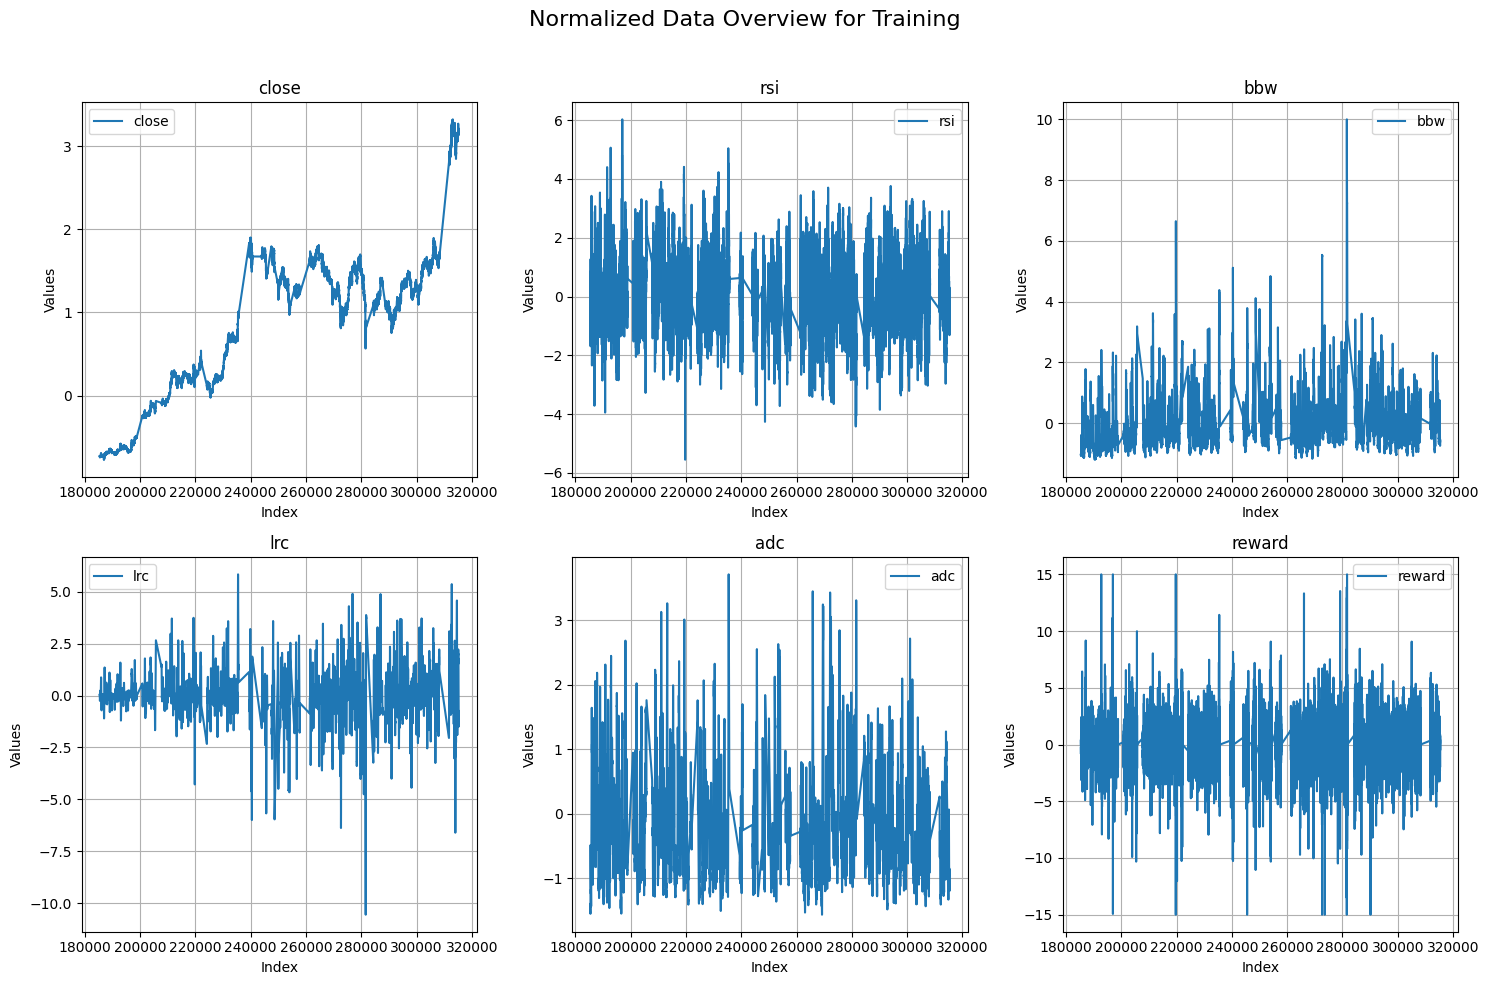

Saved normalized data plot to /content/drive/My Drive/Trading_vrm/plots_vrm2/normalized_data_overview_vrm2.png


<ipython-input-1-9730c3b0a02f>:719: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[time_column] = pd.to_datetime(df[time_column] / 1000, unit='s')


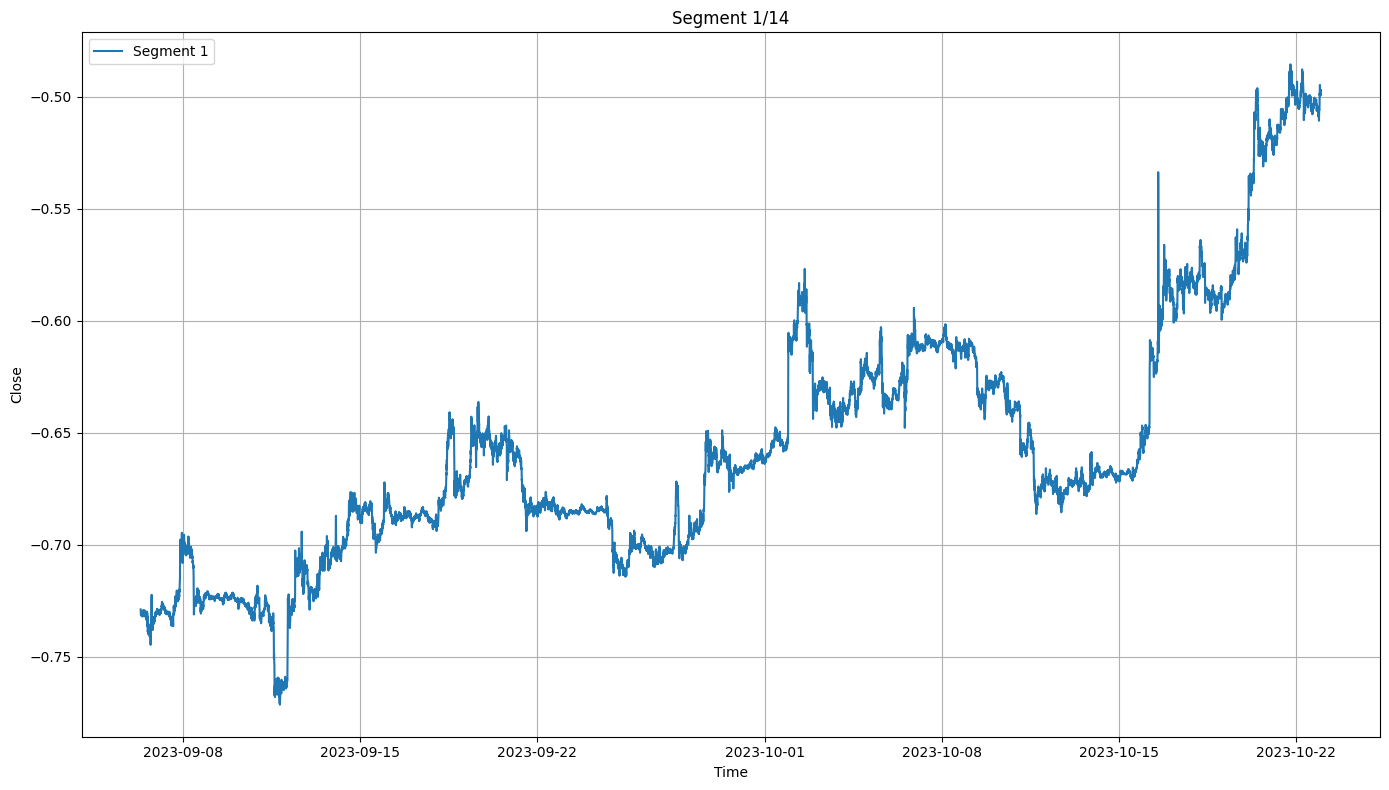

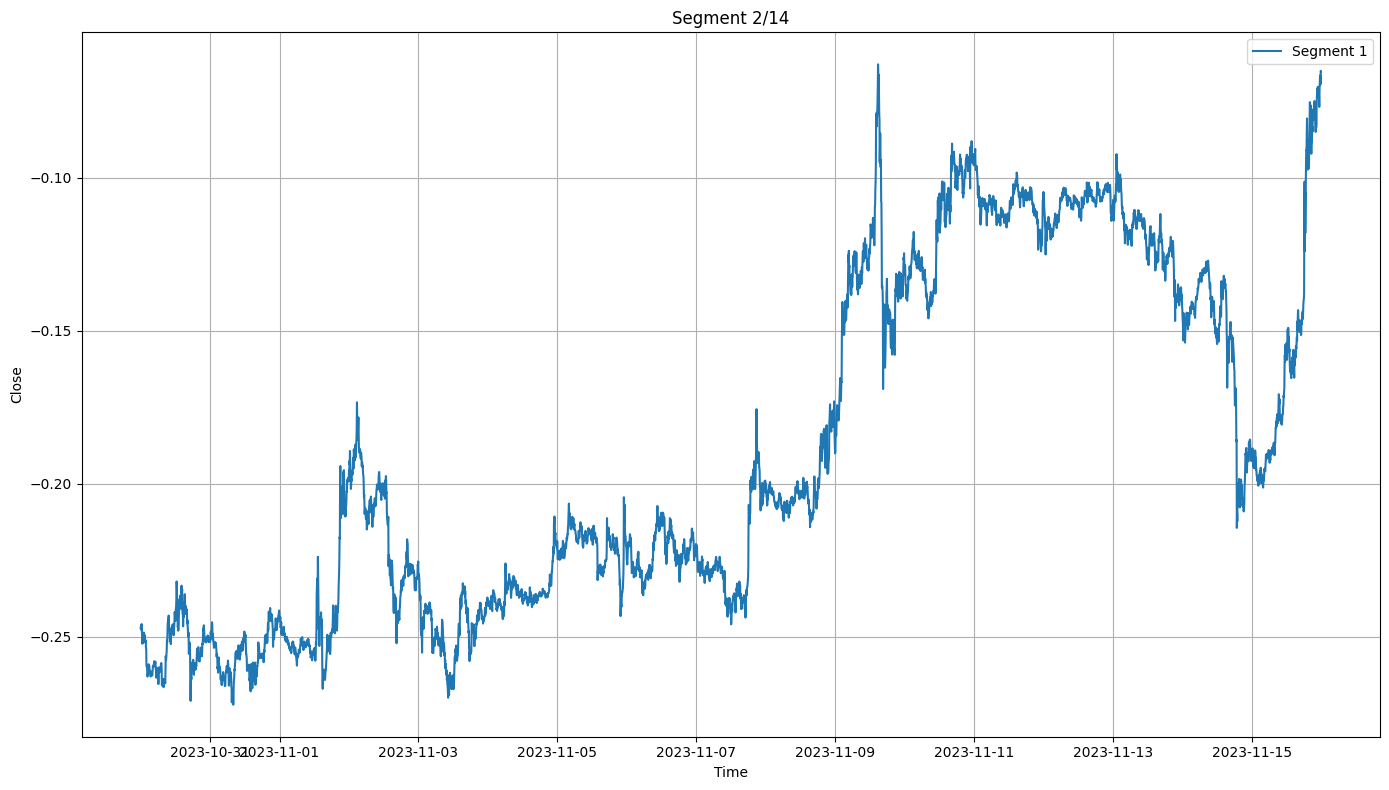

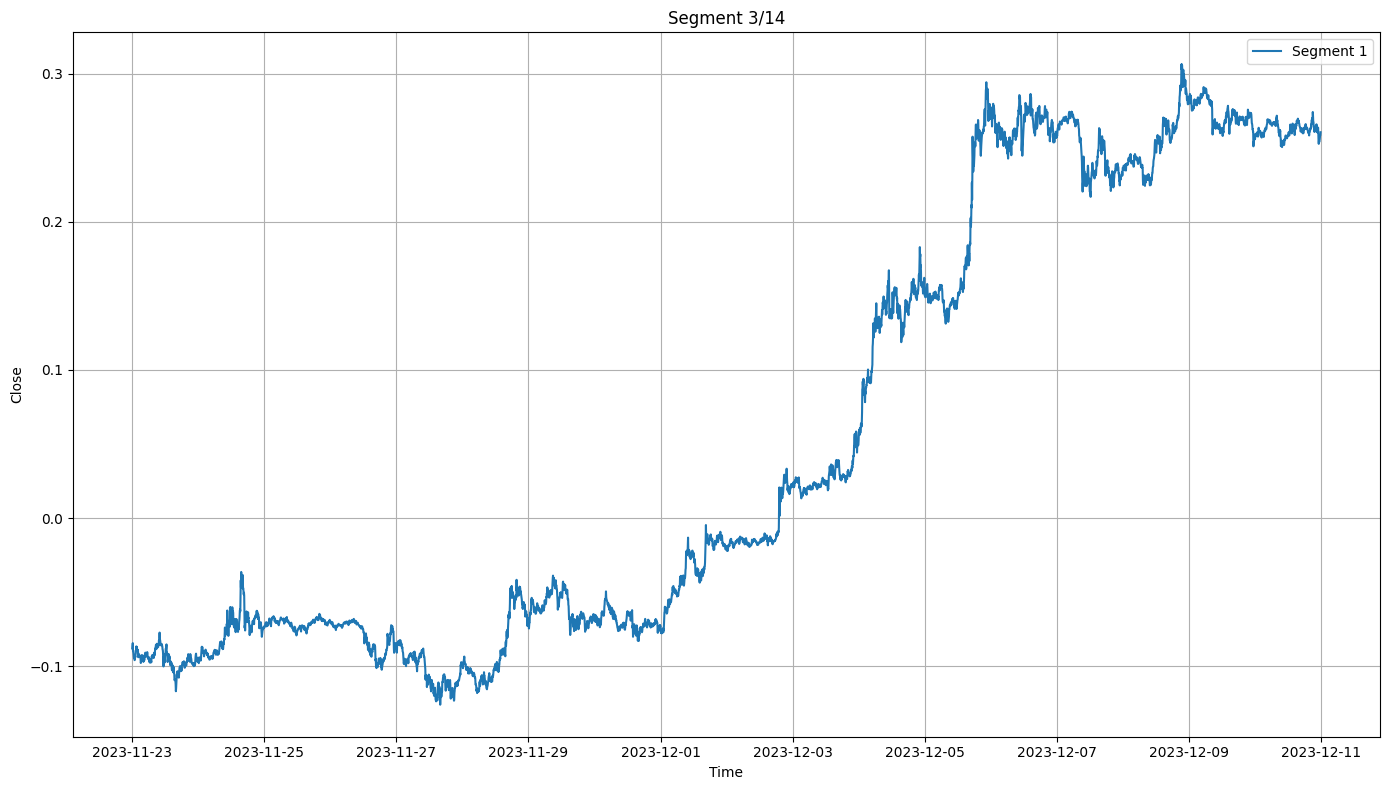

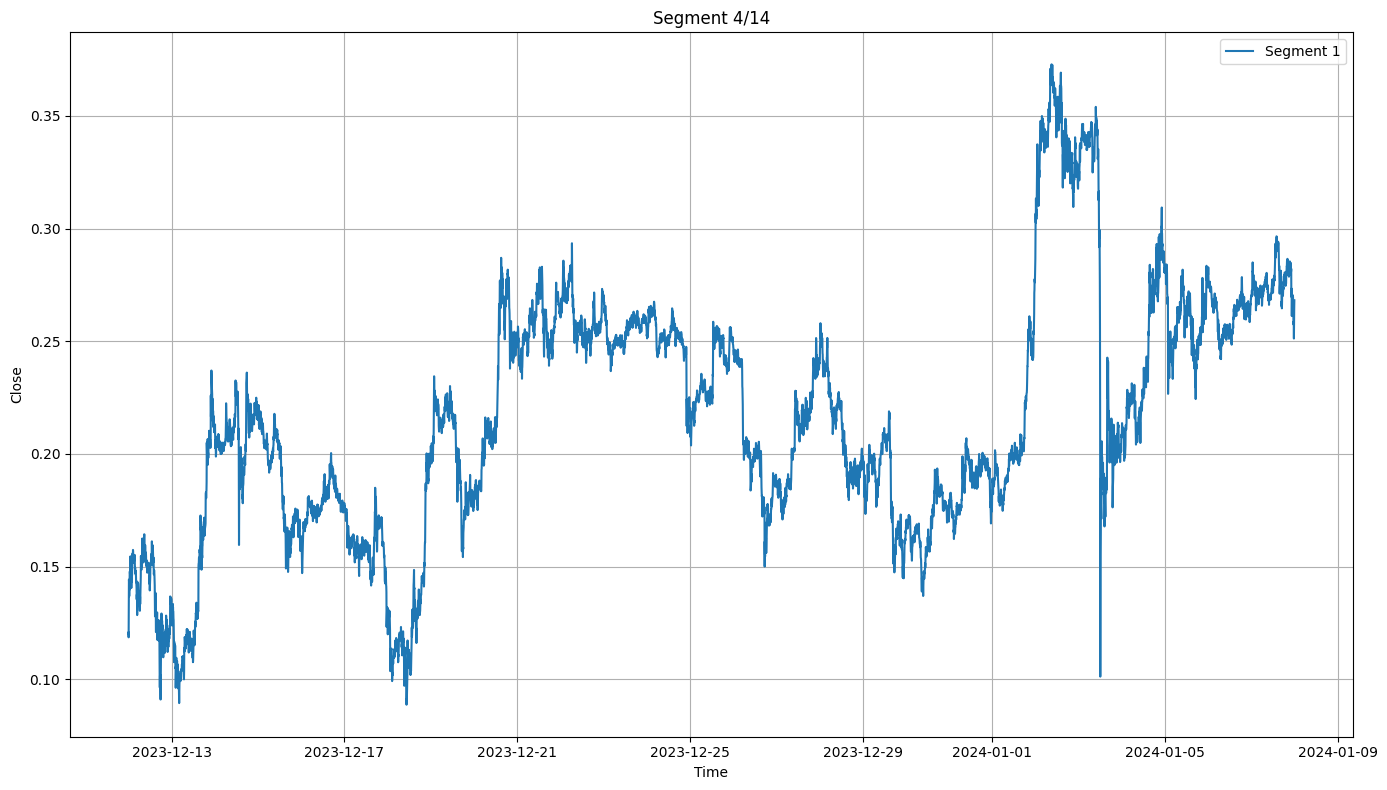

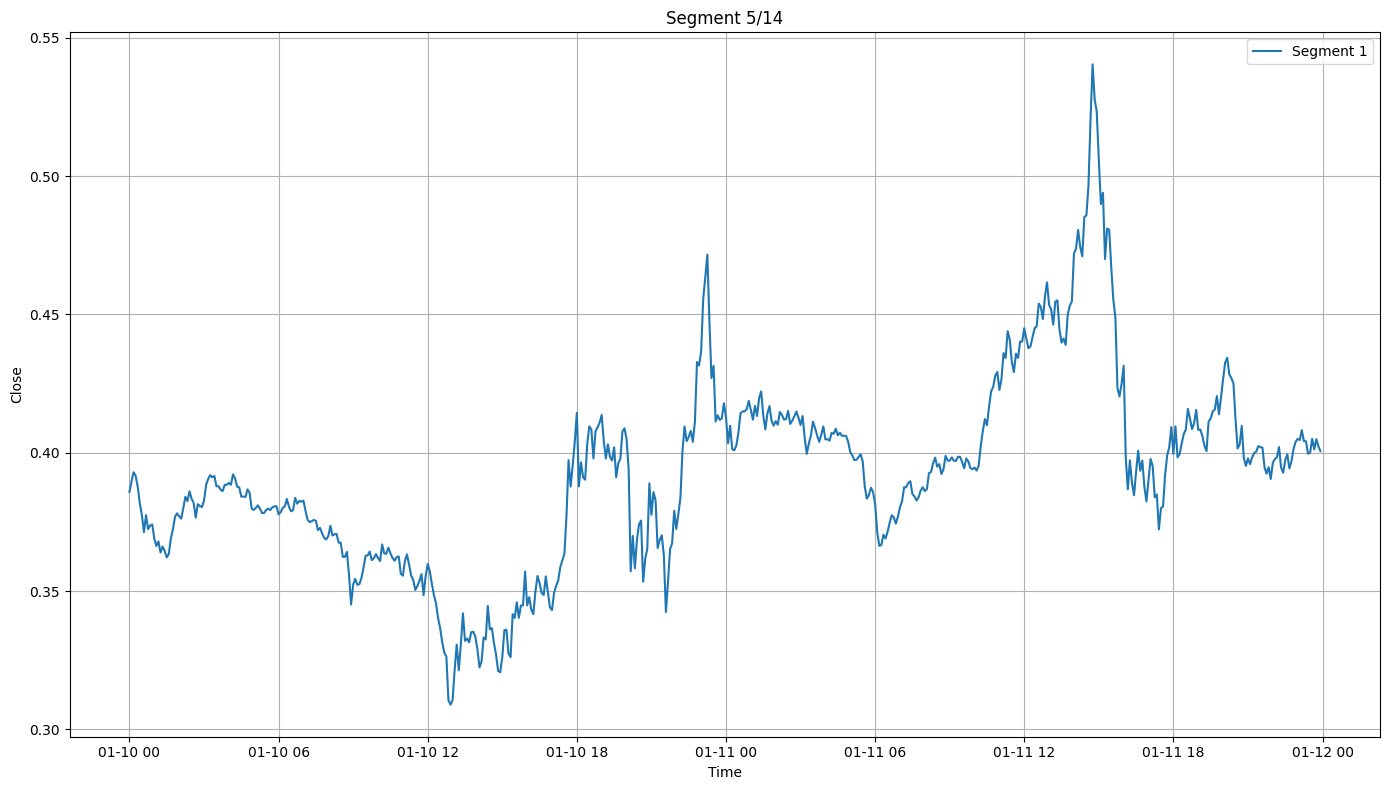

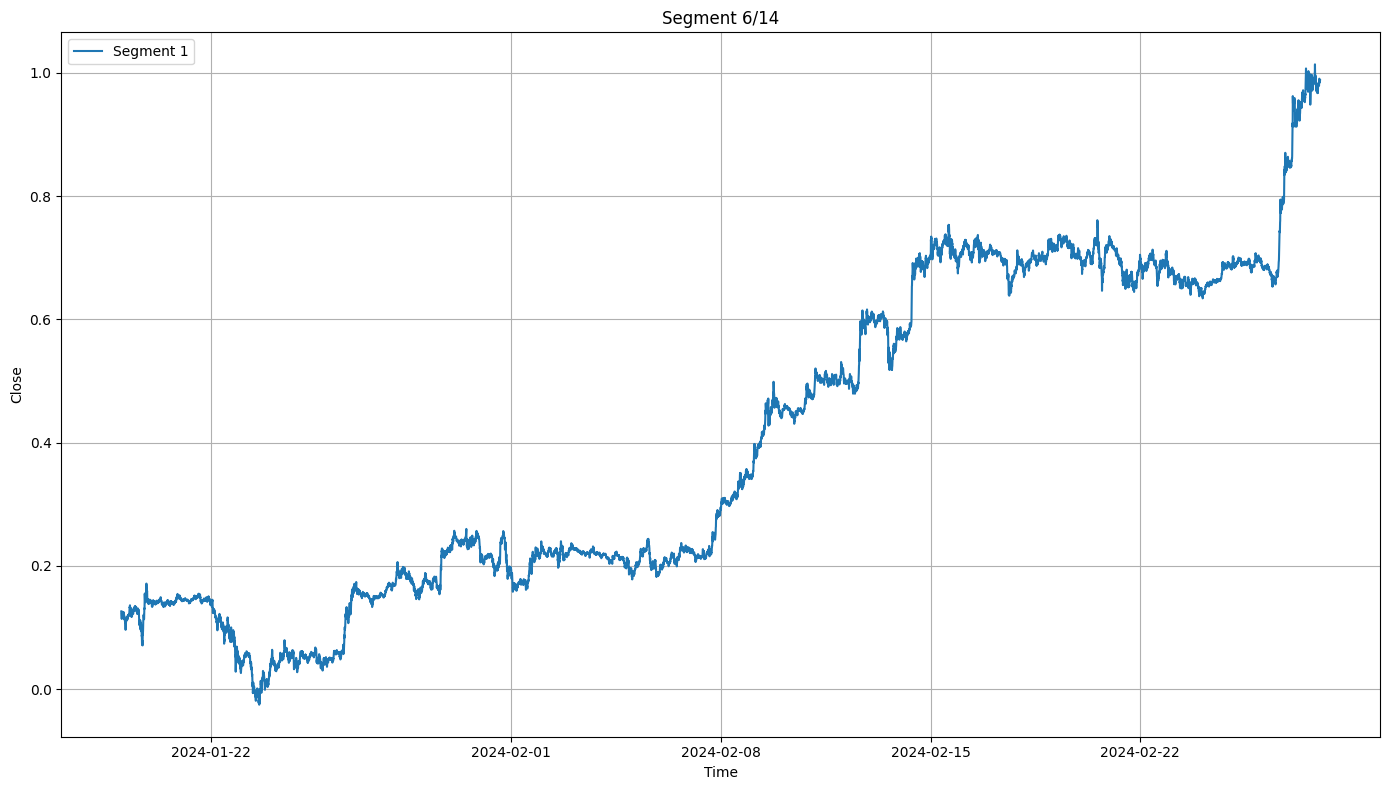

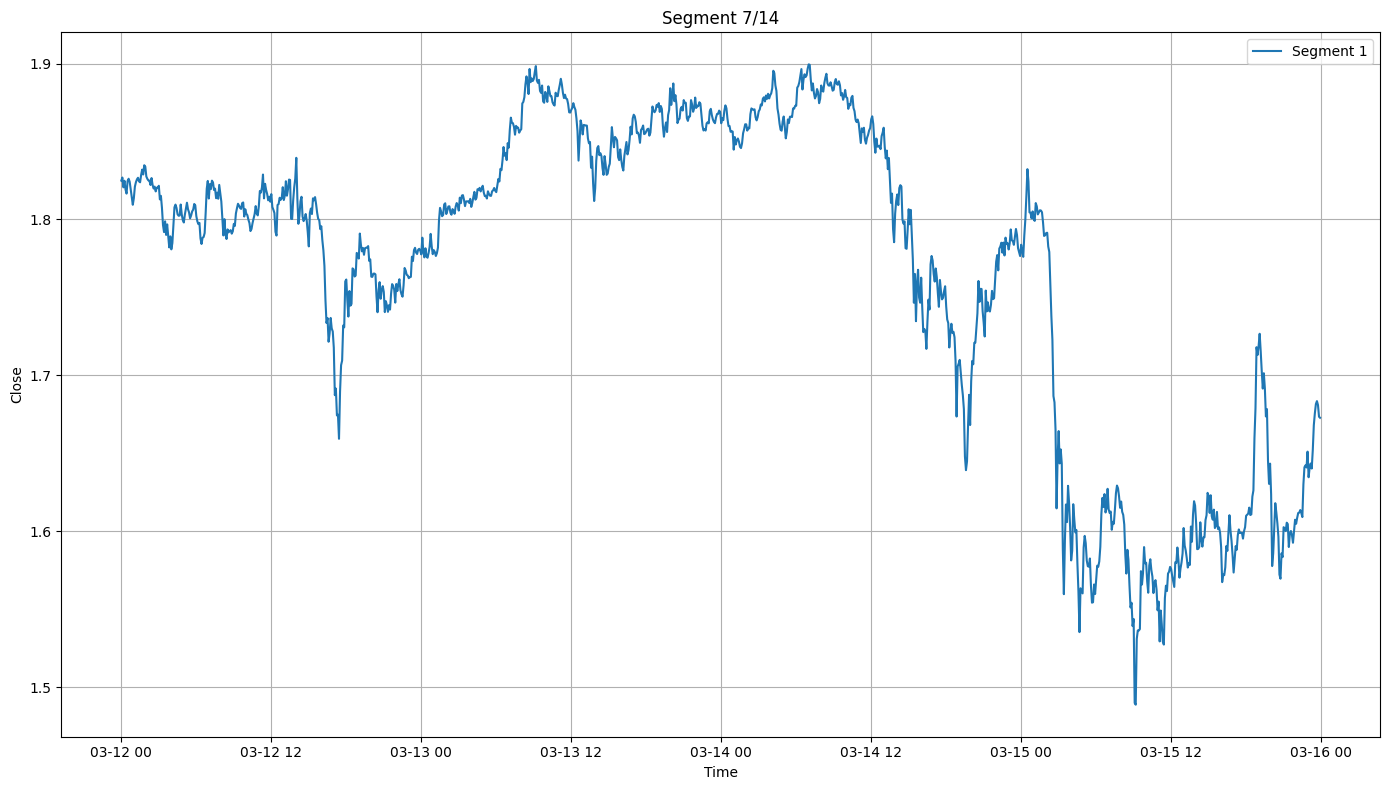

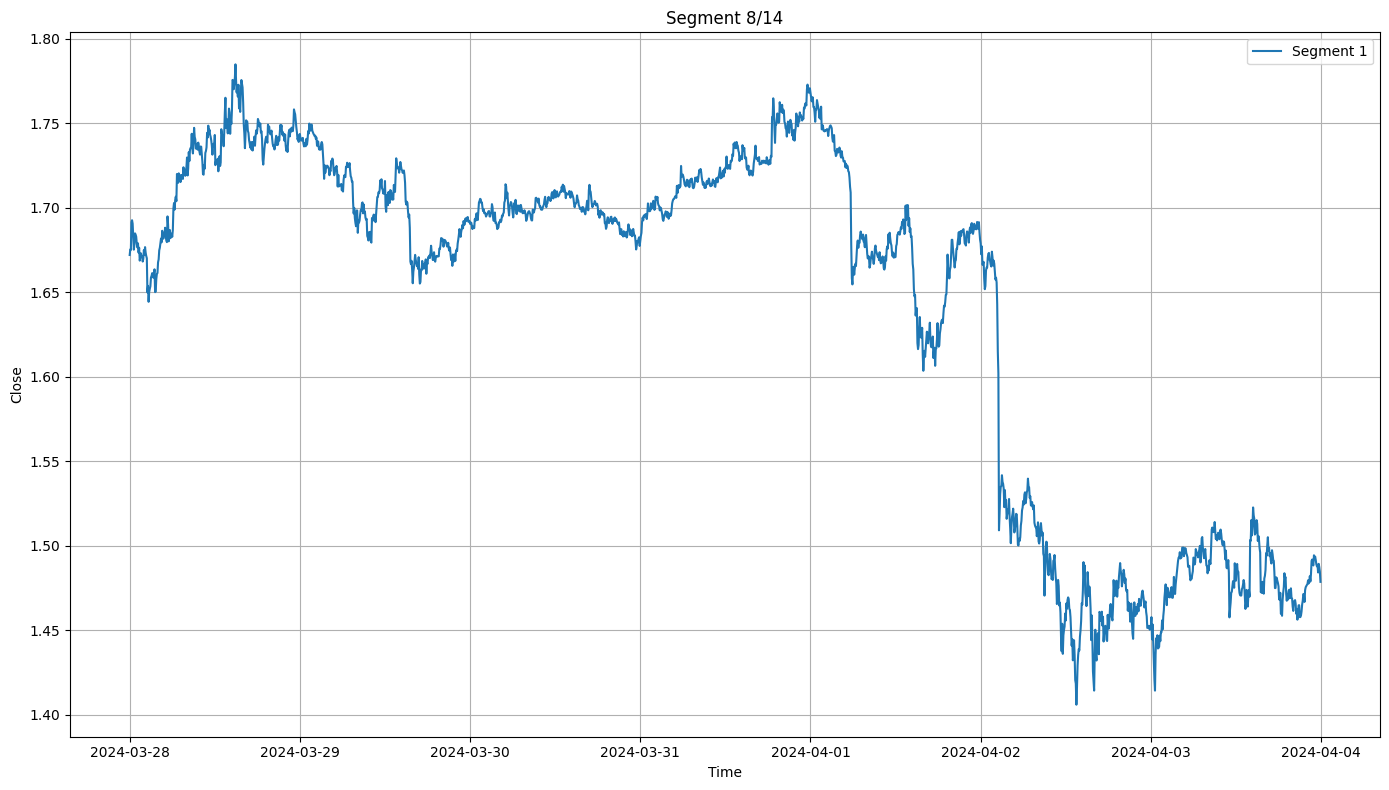

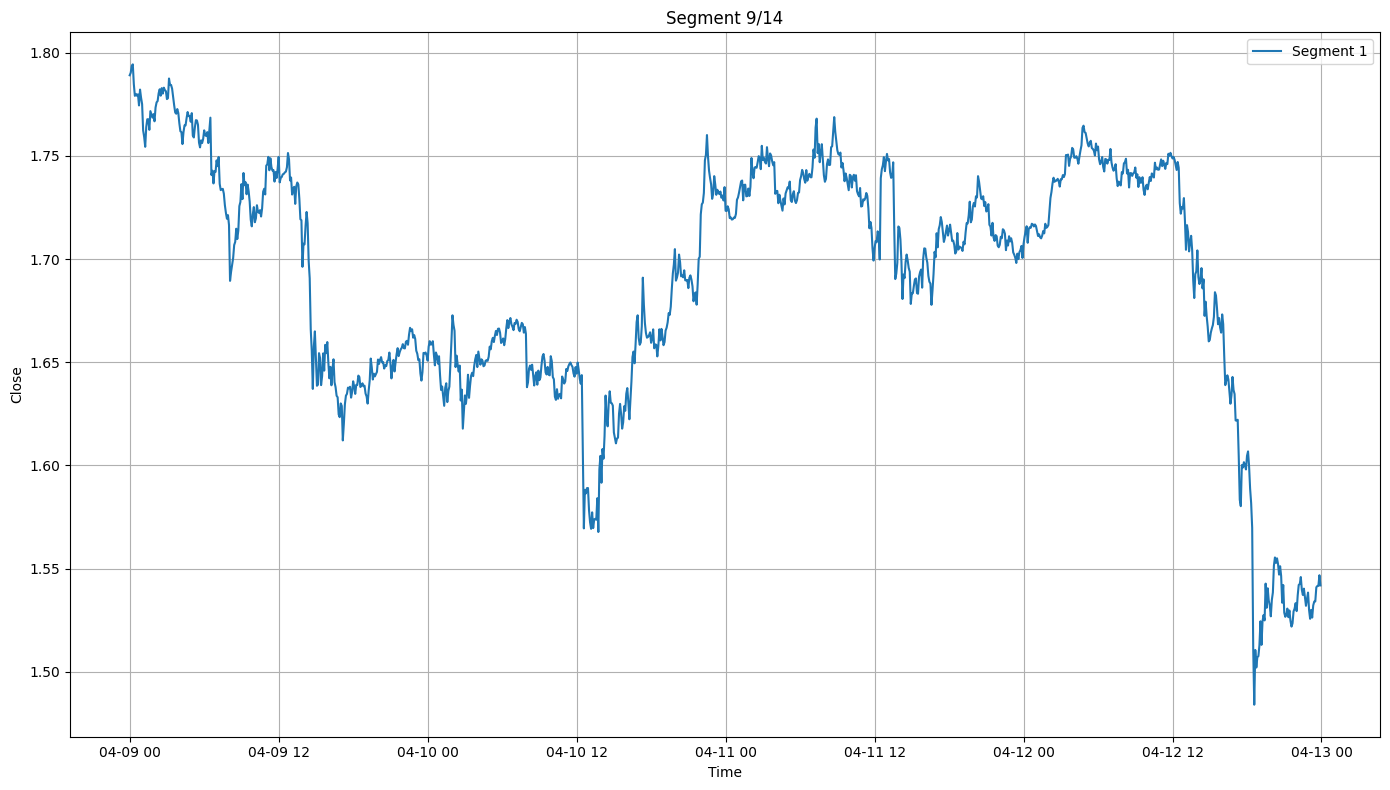

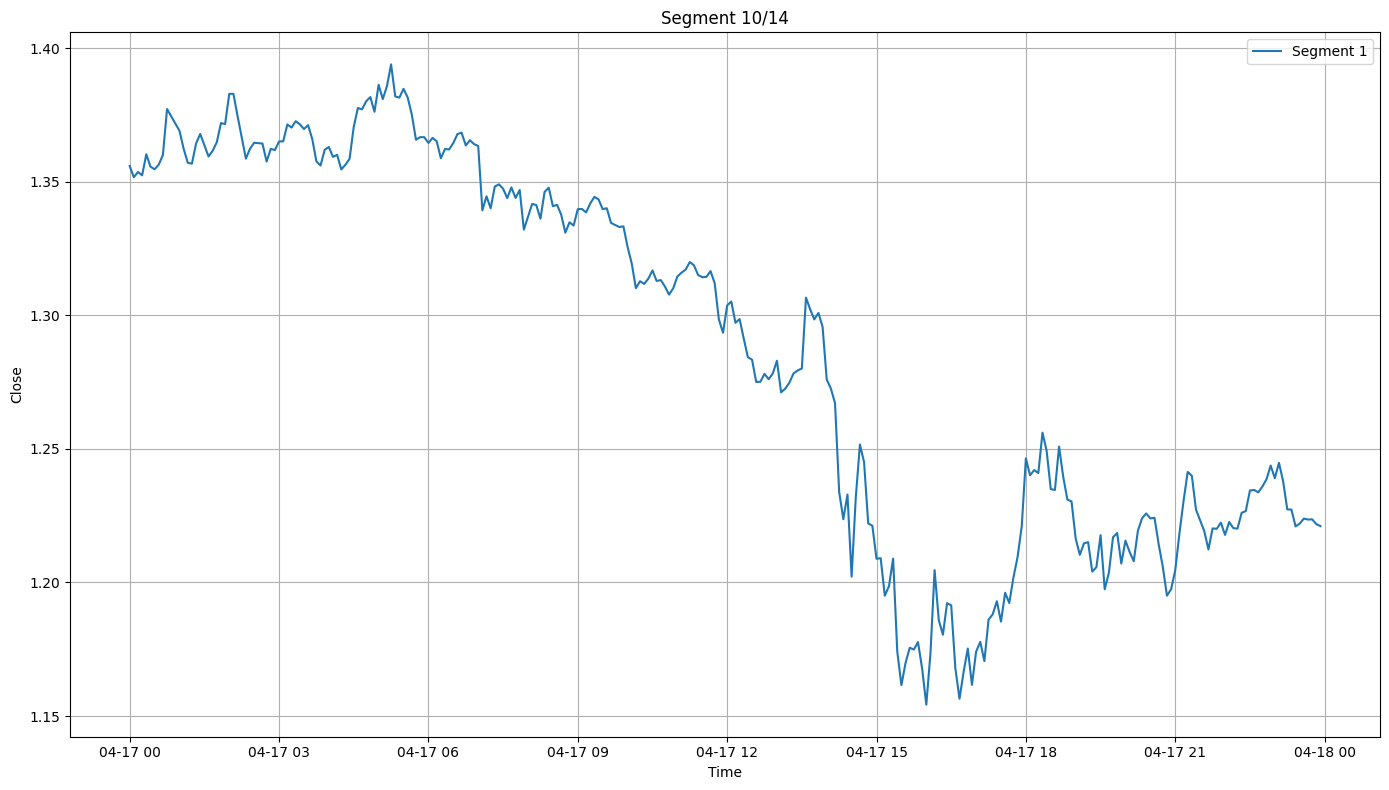

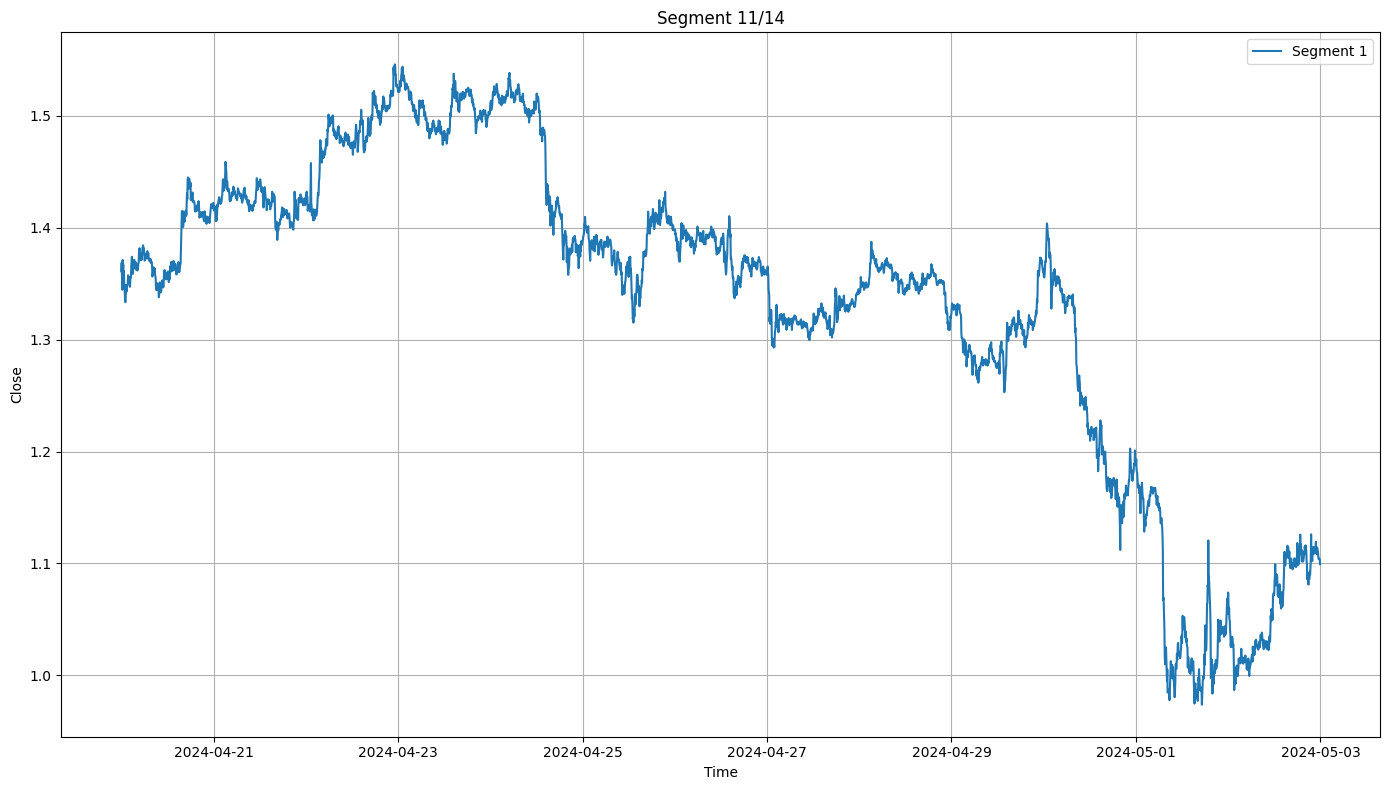

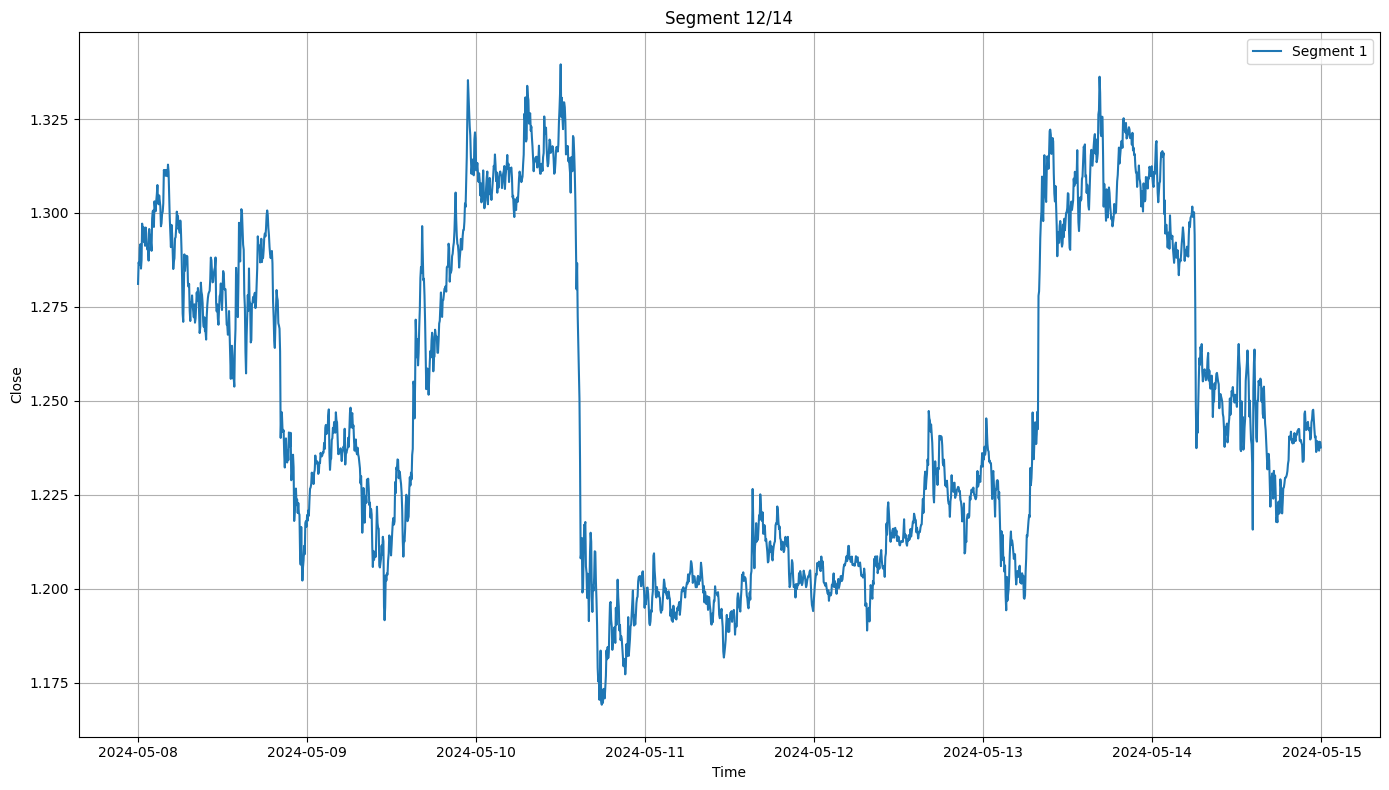

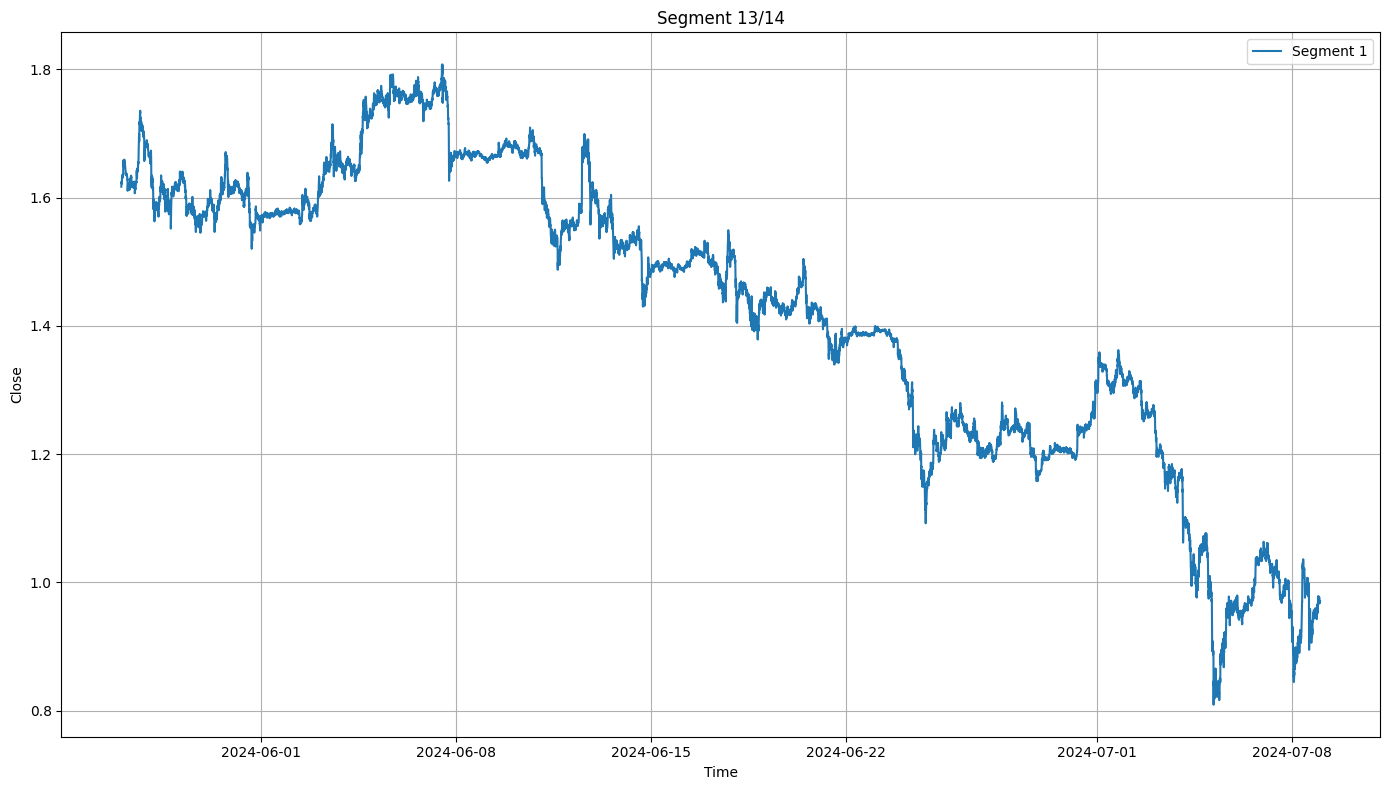

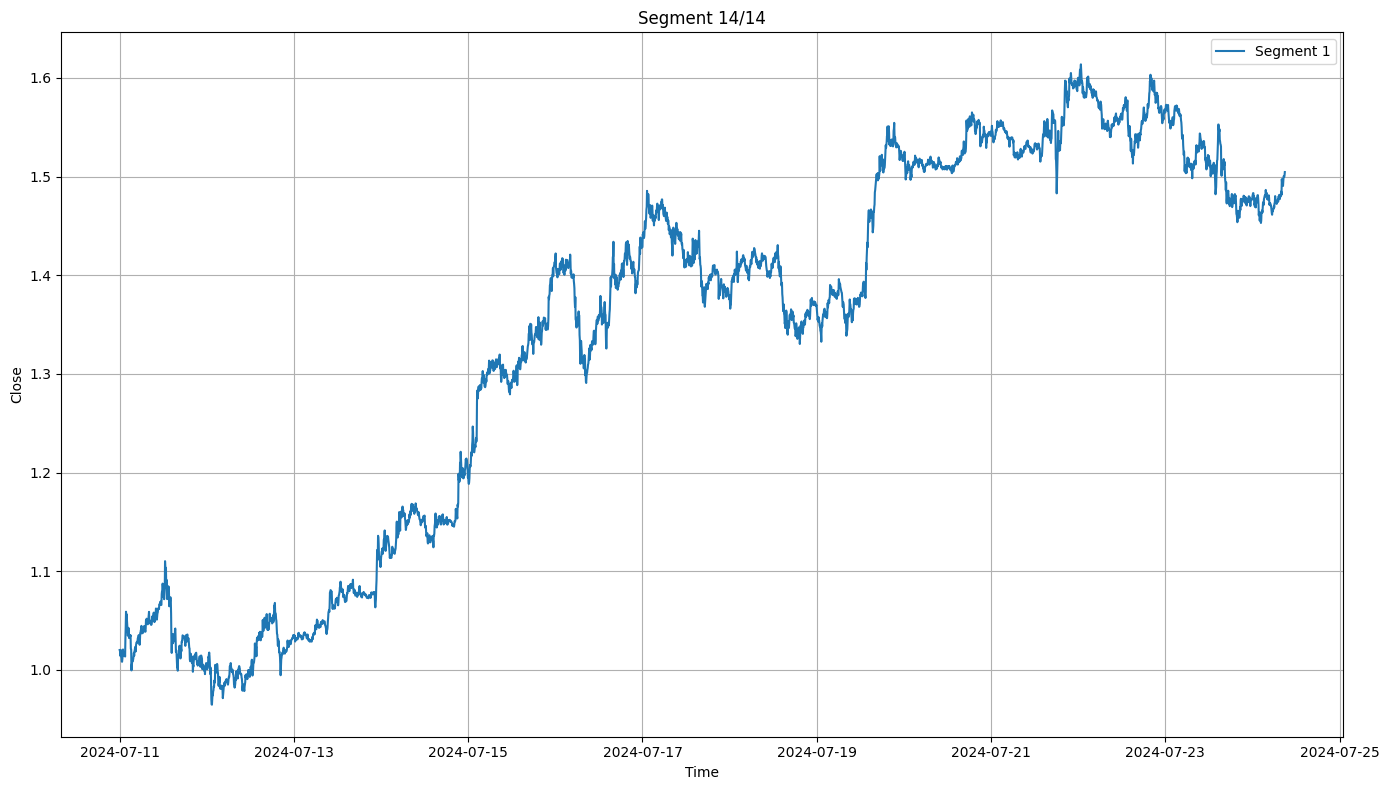

100%|█████████▉| 69999/70000 [07:15<00:00, 160.68it/s]


Saved loss plot for Episode 1 to plots2/loss_episode_1.png


100%|█████████▉| 69999/70000 [07:26<00:00, 156.78it/s]


Saved loss plot for Episode 2 to plots2/loss_episode_2.png


100%|█████████▉| 69999/70000 [07:11<00:00, 162.41it/s]


Saved loss plot for Episode 3 to plots2/loss_episode_3.png


100%|█████████▉| 69999/70000 [07:17<00:00, 159.84it/s]


Saved loss plot for Episode 4 to plots2/loss_episode_4.png


100%|█████████▉| 69999/70000 [07:10<00:00, 162.68it/s]
INFO:validation_logger:Validation: Logging model weights before evaluation.
INFO:validation_logger:Layer: fc1.weight, Mean: -0.023970147594809532, Std: 0.22802187502384186
INFO:validation_logger:Layer: fc1.bias, Mean: 0.2155989706516266, Std: 0.4350438416004181
INFO:validation_logger:Layer: fc2.weight, Mean: 0.0019305708119645715, Std: 0.1728641539812088
INFO:validation_logger:Layer: fc2.bias, Mean: 0.07257375121116638, Std: 0.31880512833595276
INFO:validation_logger:Layer: fc3.weight, Mean: -0.030944760888814926, Std: 0.2825988233089447
INFO:validation_logger:Layer: fc3.bias, Mean: 0.211626797914505, Std: 0.08409952372312546
INFO:validation_logger:Model is in evaluation mode: True
INFO:validation_logger:Initial state shape during evaluation: (5,)


Saved loss plot for Episode 5 to plots2/loss_episode_5.png


INFO:validation_logger:Final Evaluation Average Loss: 0.011220
/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
INFO:validation_logger:Validation: Logging model weights after evaluation.
INFO:validation_logger:Layer: fc1.weight, Mean: -0.023970147594809532, Std: 0.22802187502384186
INFO:validation_logger:Layer: fc1.bias, Mean: 0.2155989706516266, Std: 0.4350438416004181
INFO:validation_logger:Layer: fc2.weight, Mean: 0.0019305708119645715, Std: 0.1728641539812088
INFO:validation_logger:Layer: fc2.bias, Mean: 0.07257375121116638, Std: 0.31880512833595276
INFO:validation_logger:Layer: fc3.weight, Mean: -0.030944760888814926, Std: 0.2825988233089447
INFO:validation_logger:Layer: fc3.bias, Mean: 0.211626797914505, Std: 

Saved loss plot for Episode 6 to plots2/loss_episode_6.png


100%|█████████▉| 69999/70000 [07:22<00:00, 158.10it/s]


Saved loss plot for Episode 7 to plots2/loss_episode_7.png


100%|█████████▉| 69999/70000 [07:19<00:00, 159.19it/s]


Saved loss plot for Episode 8 to plots2/loss_episode_8.png


100%|█████████▉| 69999/70000 [07:15<00:00, 160.65it/s]


Saved loss plot for Episode 9 to plots2/loss_episode_9.png


100%|█████████▉| 69999/70000 [07:10<00:00, 162.48it/s]
INFO:validation_logger:Validation: Logging model weights before evaluation.
INFO:validation_logger:Layer: fc1.weight, Mean: -0.0547761432826519, Std: 0.2825723886489868
INFO:validation_logger:Layer: fc1.bias, Mean: 0.3139302730560303, Std: 0.6030231714248657
INFO:validation_logger:Layer: fc2.weight, Mean: -0.0014783251099288464, Std: 0.19713079929351807
INFO:validation_logger:Layer: fc2.bias, Mean: 0.08796902000904083, Std: 0.4459805488586426
INFO:validation_logger:Layer: fc3.weight, Mean: -0.05234358459711075, Std: 0.3413448631763458
INFO:validation_logger:Layer: fc3.bias, Mean: 0.2801355719566345, Std: 0.11172477900981903
INFO:validation_logger:Model is in evaluation mode: True
INFO:validation_logger:Initial state shape during evaluation: (5,)


Saved loss plot for Episode 10 to plots2/loss_episode_10.png


INFO:validation_logger:Final Evaluation Average Loss: 0.014015
INFO:validation_logger:Validation: Logging model weights after evaluation.
INFO:validation_logger:Layer: fc1.weight, Mean: -0.0547761432826519, Std: 0.2825723886489868
INFO:validation_logger:Layer: fc1.bias, Mean: 0.3139302730560303, Std: 0.6030231714248657
INFO:validation_logger:Layer: fc2.weight, Mean: -0.0014783251099288464, Std: 0.19713079929351807
INFO:validation_logger:Layer: fc2.bias, Mean: 0.08796902000904083, Std: 0.4459805488586426
INFO:validation_logger:Layer: fc3.weight, Mean: -0.05234358459711075, Std: 0.3413448631763458
INFO:validation_logger:Layer: fc3.bias, Mean: 0.2801355719566345, Std: 0.11172477900981903
INFO:validation_logger:Validation Results for Episode 10: {'Total Reward': 1341.999999999875, 'Average Trade Return': -0.000590220103443114, 'Win Rate': 0.0, 'Total Trades': 1, 'Successful Trades': 0, 'Profit Factor': 0.0, 'Sharpe Ratio': 0, 'Sortino Ratio': -936945.3675007783, 'Maximum Drawdown': 0.01856

Saved loss plot for Episode 11 to plots2/loss_episode_11.png


100%|█████████▉| 69999/70000 [07:18<00:00, 159.47it/s]


Saved loss plot for Episode 12 to plots2/loss_episode_12.png


100%|█████████▉| 69999/70000 [07:13<00:00, 161.50it/s]


Saved loss plot for Episode 13 to plots2/loss_episode_13.png


100%|█████████▉| 69999/70000 [07:17<00:00, 159.99it/s]


Saved loss plot for Episode 14 to plots2/loss_episode_14.png


100%|█████████▉| 69999/70000 [07:13<00:00, 161.63it/s]
INFO:validation_logger:Validation: Logging model weights before evaluation.
INFO:validation_logger:Layer: fc1.weight, Mean: -0.08225186914205551, Std: 0.34855908155441284
INFO:validation_logger:Layer: fc1.bias, Mean: 0.36408206820487976, Std: 0.7364848852157593
INFO:validation_logger:Layer: fc2.weight, Mean: -0.003809102810919285, Std: 0.21867063641548157
INFO:validation_logger:Layer: fc2.bias, Mean: 0.08608725666999817, Std: 0.5358248353004456
INFO:validation_logger:Layer: fc3.weight, Mean: -0.05048781633377075, Std: 0.3854210078716278
INFO:validation_logger:Layer: fc3.bias, Mean: 0.3268786072731018, Std: 0.1276744306087494
INFO:validation_logger:Model is in evaluation mode: True
INFO:validation_logger:Initial state shape during evaluation: (5,)


Saved loss plot for Episode 15 to plots2/loss_episode_15.png


INFO:validation_logger:Final Evaluation Average Loss: 0.018603
/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
INFO:validation_logger:Validation: Logging model weights after evaluation.
INFO:validation_logger:Layer: fc1.weight, Mean: -0.08225186914205551, Std: 0.34855908155441284
INFO:validation_logger:Layer: fc1.bias, Mean: 0.36408206820487976, Std: 0.7364848852157593
INFO:validation_logger:Layer: fc2.weight, Mean: -0.003809102810919285, Std: 0.21867063641548157
INFO:validation_logger:Layer: fc2.bias, Mean: 0.08608725666999817, Std: 0.5358248353004456
INFO:validation_logger:Layer: fc3.weight, Mean: -0.05048781633377075, Std: 0.3854210078716278
INFO:validation_logger:Layer: fc3.bias, Mean: 0.3268786072731018, Std: 

Saved loss plot for Episode 16 to plots2/loss_episode_16.png


100%|█████████▉| 69999/70000 [07:20<00:00, 158.92it/s]


Saved loss plot for Episode 17 to plots2/loss_episode_17.png


100%|█████████▉| 69999/70000 [07:21<00:00, 158.59it/s]


Saved loss plot for Episode 18 to plots2/loss_episode_18.png


100%|█████████▉| 69999/70000 [07:26<00:00, 156.60it/s]


Saved loss plot for Episode 19 to plots2/loss_episode_19.png


100%|█████████▉| 69999/70000 [07:34<00:00, 154.12it/s]
INFO:validation_logger:Validation: Logging model weights before evaluation.
INFO:validation_logger:Layer: fc1.weight, Mean: -0.08755616843700409, Std: 0.41391435265541077
INFO:validation_logger:Layer: fc1.bias, Mean: 0.3773123025894165, Std: 0.7860945463180542
INFO:validation_logger:Layer: fc2.weight, Mean: -0.009848047979176044, Std: 0.23240898549556732
INFO:validation_logger:Layer: fc2.bias, Mean: 0.06825976073741913, Std: 0.6090471148490906
INFO:validation_logger:Layer: fc3.weight, Mean: -0.04368605464696884, Std: 0.4293838143348694
INFO:validation_logger:Layer: fc3.bias, Mean: 0.35554760694503784, Std: 0.12500634789466858
INFO:validation_logger:Model is in evaluation mode: True
INFO:validation_logger:Initial state shape during evaluation: (5,)


Saved loss plot for Episode 20 to plots2/loss_episode_20.png


INFO:validation_logger:Final Evaluation Average Loss: 0.016743
INFO:validation_logger:Validation: Logging model weights after evaluation.
INFO:validation_logger:Layer: fc1.weight, Mean: -0.08755616843700409, Std: 0.41391435265541077
INFO:validation_logger:Layer: fc1.bias, Mean: 0.3773123025894165, Std: 0.7860945463180542
INFO:validation_logger:Layer: fc2.weight, Mean: -0.009848047979176044, Std: 0.23240898549556732
INFO:validation_logger:Layer: fc2.bias, Mean: 0.06825976073741913, Std: 0.6090471148490906
INFO:validation_logger:Layer: fc3.weight, Mean: -0.04368605464696884, Std: 0.4293838143348694
INFO:validation_logger:Layer: fc3.bias, Mean: 0.35554760694503784, Std: 0.12500634789466858
INFO:validation_logger:Validation Results for Episode 20: {'Total Reward': 1233.5999999999735, 'Average Trade Return': -0.0005937310965867982, 'Win Rate': 0.0, 'Total Trades': 1, 'Successful Trades': 0, 'Profit Factor': 0.0, 'Sharpe Ratio': 0, 'Sortino Ratio': -942518.8937125877, 'Maximum Drawdown': 0.0

Saved loss plot for Episode 21 to plots2/loss_episode_21.png


100%|█████████▉| 69999/70000 [07:30<00:00, 155.53it/s]


Saved loss plot for Episode 22 to plots2/loss_episode_22.png


100%|█████████▉| 69999/70000 [07:27<00:00, 156.43it/s]


Saved loss plot for Episode 23 to plots2/loss_episode_23.png


100%|█████████▉| 69999/70000 [07:28<00:00, 156.06it/s]


Saved loss plot for Episode 24 to plots2/loss_episode_24.png


100%|█████████▉| 69999/70000 [07:24<00:00, 157.47it/s]
INFO:validation_logger:Validation: Logging model weights before evaluation.
INFO:validation_logger:Layer: fc1.weight, Mean: -0.08981349319219589, Std: 0.46147578954696655
INFO:validation_logger:Layer: fc1.bias, Mean: 0.3905057907104492, Std: 0.8267235159873962
INFO:validation_logger:Layer: fc2.weight, Mean: -0.014802913181483746, Std: 0.24353262782096863
INFO:validation_logger:Layer: fc2.bias, Mean: 0.05426318198442459, Std: 0.6686716079711914
INFO:validation_logger:Layer: fc3.weight, Mean: -0.03745315223932266, Std: 0.4625403583049774
INFO:validation_logger:Layer: fc3.bias, Mean: 0.37873971462249756, Std: 0.08648361265659332
INFO:validation_logger:Model is in evaluation mode: True
INFO:validation_logger:Initial state shape during evaluation: (5,)


Saved loss plot for Episode 25 to plots2/loss_episode_25.png


INFO:validation_logger:Final Evaluation Average Loss: 0.014694
/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
INFO:validation_logger:Validation: Logging model weights after evaluation.
INFO:validation_logger:Layer: fc1.weight, Mean: -0.08981349319219589, Std: 0.46147578954696655
INFO:validation_logger:Layer: fc1.bias, Mean: 0.3905057907104492, Std: 0.8267235159873962
INFO:validation_logger:Layer: fc2.weight, Mean: -0.014802913181483746, Std: 0.24353262782096863
INFO:validation_logger:Layer: fc2.bias, Mean: 0.05426318198442459, Std: 0.6686716079711914
INFO:validation_logger:Layer: fc3.weight, Mean: -0.03745315223932266, Std: 0.4625403583049774
INFO:validation_logger:Layer: fc3.bias, Mean: 0.37873971462249756, Std: 

Saved loss plot for Episode 26 to plots2/loss_episode_26.png


100%|█████████▉| 69999/70000 [07:38<00:00, 152.73it/s]


Saved loss plot for Episode 27 to plots2/loss_episode_27.png


100%|█████████▉| 69999/70000 [07:28<00:00, 156.15it/s]


Saved loss plot for Episode 28 to plots2/loss_episode_28.png


100%|█████████▉| 69999/70000 [07:22<00:00, 158.23it/s]


Saved loss plot for Episode 29 to plots2/loss_episode_29.png


100%|█████████▉| 69999/70000 [07:10<00:00, 162.76it/s]
INFO:validation_logger:Validation: Logging model weights before evaluation.
INFO:validation_logger:Layer: fc1.weight, Mean: -0.10100705921649933, Std: 0.5404211282730103
INFO:validation_logger:Layer: fc1.bias, Mean: 0.3828486502170563, Std: 0.8189749717712402
INFO:validation_logger:Layer: fc2.weight, Mean: -0.019140897318720818, Std: 0.25806164741516113
INFO:validation_logger:Layer: fc2.bias, Mean: 0.028532849624753, Std: 0.730926513671875
INFO:validation_logger:Layer: fc3.weight, Mean: -0.03339068591594696, Std: 0.4951484501361847
INFO:validation_logger:Layer: fc3.bias, Mean: 0.41199395060539246, Std: 0.10733594000339508
INFO:validation_logger:Model is in evaluation mode: True
INFO:validation_logger:Initial state shape during evaluation: (5,)


Saved loss plot for Episode 30 to plots2/loss_episode_30.png


INFO:validation_logger:Final Evaluation Average Loss: 0.018340
<ipython-input-1-9730c3b0a02f>:275: RuntimeWarning: divide by zero encountered in scalar divide
  sum(r for r in realized_profits_v if r > 0) /
INFO:validation_logger:Validation: Logging model weights after evaluation.
INFO:validation_logger:Layer: fc1.weight, Mean: -0.10100705921649933, Std: 0.5404211282730103
INFO:validation_logger:Layer: fc1.bias, Mean: 0.3828486502170563, Std: 0.8189749717712402
INFO:validation_logger:Layer: fc2.weight, Mean: -0.019140897318720818, Std: 0.25806164741516113
INFO:validation_logger:Layer: fc2.bias, Mean: 0.028532849624753, Std: 0.730926513671875
INFO:validation_logger:Layer: fc3.weight, Mean: -0.03339068591594696, Std: 0.4951484501361847
INFO:validation_logger:Layer: fc3.bias, Mean: 0.41199395060539246, Std: 0.10733594000339508
INFO:validation_logger:Validation Results for Episode 30: {'Total Reward': 947.6855591035791, 'Average Trade Return': 0.0036855591034330036, 'Win Rate': 1.0, 'Total

Saved loss plot for Episode 31 to plots2/loss_episode_31.png


100%|█████████▉| 69999/70000 [07:10<00:00, 162.66it/s]


Saved loss plot for Episode 32 to plots2/loss_episode_32.png


100%|█████████▉| 69999/70000 [07:12<00:00, 161.87it/s]


Saved loss plot for Episode 33 to plots2/loss_episode_33.png


100%|█████████▉| 69999/70000 [07:12<00:00, 161.78it/s]


Saved loss plot for Episode 34 to plots2/loss_episode_34.png


100%|█████████▉| 69999/70000 [07:10<00:00, 162.75it/s]
INFO:validation_logger:Validation: Logging model weights before evaluation.
INFO:validation_logger:Layer: fc1.weight, Mean: -0.10325703769922256, Std: 0.5852577686309814
INFO:validation_logger:Layer: fc1.bias, Mean: 0.39499592781066895, Std: 0.8546721935272217
INFO:validation_logger:Layer: fc2.weight, Mean: -0.01976504549384117, Std: 0.2732316851615906
INFO:validation_logger:Layer: fc2.bias, Mean: 0.029078051447868347, Std: 0.7754732966423035
INFO:validation_logger:Layer: fc3.weight, Mean: -0.029898682609200478, Std: 0.527916669845581
INFO:validation_logger:Layer: fc3.bias, Mean: 0.46998852491378784, Std: 0.14419157803058624
INFO:validation_logger:Model is in evaluation mode: True
INFO:validation_logger:Initial state shape during evaluation: (5,)


Saved loss plot for Episode 35 to plots2/loss_episode_35.png


INFO:validation_logger:Final Evaluation Average Loss: 0.026808
<ipython-input-1-9730c3b0a02f>:275: RuntimeWarning: divide by zero encountered in scalar divide
  sum(r for r in realized_profits_v if r > 0) /
INFO:validation_logger:Validation: Logging model weights after evaluation.
INFO:validation_logger:Layer: fc1.weight, Mean: -0.10325703769922256, Std: 0.5852577686309814
INFO:validation_logger:Layer: fc1.bias, Mean: 0.39499592781066895, Std: 0.8546721935272217
INFO:validation_logger:Layer: fc2.weight, Mean: -0.01976504549384117, Std: 0.2732316851615906
INFO:validation_logger:Layer: fc2.bias, Mean: 0.029078051447868347, Std: 0.7754732966423035
INFO:validation_logger:Layer: fc3.weight, Mean: -0.029898682609200478, Std: 0.527916669845581
INFO:validation_logger:Layer: fc3.bias, Mean: 0.46998852491378784, Std: 0.14419157803058624
INFO:validation_logger:Validation Results for Episode 35: {'Total Reward': 1031.511038325339, 'Average Trade Return': 0.0007555191625907739, 'Win Rate': 1.0, 'To

Saved loss plot for Episode 36 to plots2/loss_episode_36.png


100%|█████████▉| 69999/70000 [07:07<00:00, 163.71it/s]


Saved loss plot for Episode 37 to plots2/loss_episode_37.png


100%|█████████▉| 69999/70000 [07:17<00:00, 159.96it/s]


Saved loss plot for Episode 38 to plots2/loss_episode_38.png


100%|█████████▉| 69999/70000 [07:12<00:00, 161.68it/s]


Saved loss plot for Episode 39 to plots2/loss_episode_39.png


100%|█████████▉| 69999/70000 [07:12<00:00, 161.82it/s]
INFO:validation_logger:Validation: Logging model weights before evaluation.
INFO:validation_logger:Layer: fc1.weight, Mean: -0.10049915313720703, Std: 0.6449515223503113
INFO:validation_logger:Layer: fc1.bias, Mean: 0.3984379768371582, Std: 0.8830947875976562
INFO:validation_logger:Layer: fc2.weight, Mean: -0.023419877514243126, Std: 0.28584524989128113
INFO:validation_logger:Layer: fc2.bias, Mean: 0.02074216492474079, Std: 0.8264871835708618
INFO:validation_logger:Layer: fc3.weight, Mean: -0.027079224586486816, Std: 0.5447484254837036
INFO:validation_logger:Layer: fc3.bias, Mean: 0.4975484311580658, Std: 0.1357327699661255
INFO:validation_logger:Model is in evaluation mode: True
INFO:validation_logger:Initial state shape during evaluation: (5,)


Saved loss plot for Episode 40 to plots2/loss_episode_40.png


INFO:validation_logger:Final Evaluation Average Loss: 0.014320
/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
INFO:validation_logger:Validation: Logging model weights after evaluation.
INFO:validation_logger:Layer: fc1.weight, Mean: -0.10049915313720703, Std: 0.6449515223503113
INFO:validation_logger:Layer: fc1.bias, Mean: 0.3984379768371582, Std: 0.8830947875976562
INFO:validation_logger:Layer: fc2.weight, Mean: -0.023419877514243126, Std: 0.28584524989128113
INFO:validation_logger:Layer: fc2.bias, Mean: 0.02074216492474079, Std: 0.8264871835708618
INFO:validation_logger:Layer: fc3.weight, Mean: -0.027079224586486816, Std: 0.5447484254837036
INFO:validation_logger:Layer: fc3.bias, Mean: 0.4975484311580658, Std: 0

Saved loss plot for Episode 41 to plots2/loss_episode_41.png


100%|█████████▉| 69999/70000 [07:19<00:00, 159.15it/s]


Saved loss plot for Episode 42 to plots2/loss_episode_42.png


100%|█████████▉| 69999/70000 [07:15<00:00, 160.81it/s]


Saved loss plot for Episode 43 to plots2/loss_episode_43.png


100%|█████████▉| 69999/70000 [07:20<00:00, 159.08it/s]


Saved loss plot for Episode 44 to plots2/loss_episode_44.png


100%|█████████▉| 69999/70000 [07:20<00:00, 159.07it/s]
INFO:validation_logger:Validation: Logging model weights before evaluation.
INFO:validation_logger:Layer: fc1.weight, Mean: -0.09296327829360962, Std: 0.6983625292778015
INFO:validation_logger:Layer: fc1.bias, Mean: 0.38449251651763916, Std: 0.9099425077438354
INFO:validation_logger:Layer: fc2.weight, Mean: -0.027578596025705338, Std: 0.29872310161590576
INFO:validation_logger:Layer: fc2.bias, Mean: 0.006141837686300278, Std: 0.8425313830375671
INFO:validation_logger:Layer: fc3.weight, Mean: -0.014410655945539474, Std: 0.5697682499885559
INFO:validation_logger:Layer: fc3.bias, Mean: 0.512511134147644, Std: 0.14217297732830048
INFO:validation_logger:Model is in evaluation mode: True
INFO:validation_logger:Initial state shape during evaluation: (5,)


Saved loss plot for Episode 45 to plots2/loss_episode_45.png


INFO:validation_logger:Final Evaluation Average Loss: 0.020512
/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
INFO:validation_logger:Validation: Logging model weights after evaluation.
INFO:validation_logger:Layer: fc1.weight, Mean: -0.09296327829360962, Std: 0.6983625292778015
INFO:validation_logger:Layer: fc1.bias, Mean: 0.38449251651763916, Std: 0.9099425077438354
INFO:validation_logger:Layer: fc2.weight, Mean: -0.027578596025705338, Std: 0.29872310161590576
INFO:validation_logger:Layer: fc2.bias, Mean: 0.006141837686300278, Std: 0.8425313830375671
INFO:validation_logger:Layer: fc3.weight, Mean: -0.014410655945539474, Std: 0.5697682499885559
INFO:validation_logger:Layer: fc3.bias, Mean: 0.512511134147644, Std: 

Saved loss plot for Episode 46 to plots2/loss_episode_46.png


100%|█████████▉| 69999/70000 [07:25<00:00, 157.03it/s]


Saved loss plot for Episode 47 to plots2/loss_episode_47.png


100%|█████████▉| 69999/70000 [07:39<00:00, 152.38it/s]


Saved loss plot for Episode 48 to plots2/loss_episode_48.png


100%|█████████▉| 69999/70000 [07:38<00:00, 152.56it/s]


Saved loss plot for Episode 49 to plots2/loss_episode_49.png


100%|█████████▉| 69999/70000 [07:36<00:00, 153.46it/s]
INFO:validation_logger:Validation: Logging model weights before evaluation.
INFO:validation_logger:Layer: fc1.weight, Mean: -0.08813463896512985, Std: 0.7439916133880615
INFO:validation_logger:Layer: fc1.bias, Mean: 0.3811032176017761, Std: 0.9232796430587769
INFO:validation_logger:Layer: fc2.weight, Mean: -0.0350700281560421, Std: 0.30815091729164124
INFO:validation_logger:Layer: fc2.bias, Mean: -0.019655469805002213, Std: 0.8466464877128601
INFO:validation_logger:Layer: fc3.weight, Mean: -0.000608149915933609, Std: 0.61508709192276
INFO:validation_logger:Layer: fc3.bias, Mean: 0.5203859806060791, Std: 0.1154865026473999
INFO:validation_logger:Model is in evaluation mode: True
INFO:validation_logger:Initial state shape during evaluation: (5,)


Saved loss plot for Episode 50 to plots2/loss_episode_50.png


INFO:validation_logger:Final Evaluation Average Loss: 0.017582
<ipython-input-1-9730c3b0a02f>:275: RuntimeWarning: divide by zero encountered in scalar divide
  sum(r for r in realized_profits_v if r > 0) /
INFO:validation_logger:Validation: Logging model weights after evaluation.
INFO:validation_logger:Layer: fc1.weight, Mean: -0.08813463896512985, Std: 0.7439916133880615
INFO:validation_logger:Layer: fc1.bias, Mean: 0.3811032176017761, Std: 0.9232796430587769
INFO:validation_logger:Layer: fc2.weight, Mean: -0.0350700281560421, Std: 0.30815091729164124
INFO:validation_logger:Layer: fc2.bias, Mean: -0.019655469805002213, Std: 0.8466464877128601
INFO:validation_logger:Layer: fc3.weight, Mean: -0.000608149915933609, Std: 0.61508709192276
INFO:validation_logger:Layer: fc3.bias, Mean: 0.5203859806060791, Std: 0.1154865026473999
INFO:validation_logger:Validation Results for Episode 50: {'Total Reward': 1494.496028690114, 'Average Trade Return': 0.011496028690380038, 'Win Rate': 1.0, 'Total 

Saved loss plot for Episode 51 to plots2/loss_episode_51.png


100%|█████████▉| 69999/70000 [07:18<00:00, 159.73it/s]


Saved loss plot for Episode 52 to plots2/loss_episode_52.png


100%|█████████▉| 69999/70000 [07:39<00:00, 152.37it/s]


Saved loss plot for Episode 53 to plots2/loss_episode_53.png


100%|█████████▉| 69999/70000 [07:43<00:00, 150.86it/s]


Saved loss plot for Episode 54 to plots2/loss_episode_54.png


100%|█████████▉| 69999/70000 [07:45<00:00, 150.47it/s]
INFO:validation_logger:Validation: Logging model weights before evaluation.
INFO:validation_logger:Layer: fc1.weight, Mean: -0.09318523108959198, Std: 0.7906411290168762
INFO:validation_logger:Layer: fc1.bias, Mean: 0.3729259967803955, Std: 0.948763906955719
INFO:validation_logger:Layer: fc2.weight, Mean: -0.040637291967868805, Std: 0.31765908002853394
INFO:validation_logger:Layer: fc2.bias, Mean: -0.03660362958908081, Std: 0.8344104886054993
INFO:validation_logger:Layer: fc3.weight, Mean: 0.0031435787677764893, Std: 0.640468955039978
INFO:validation_logger:Layer: fc3.bias, Mean: 0.5354936122894287, Std: 0.0867404192686081
INFO:validation_logger:Model is in evaluation mode: True
INFO:validation_logger:Initial state shape during evaluation: (5,)


Saved loss plot for Episode 55 to plots2/loss_episode_55.png


INFO:validation_logger:Final Evaluation Average Loss: 0.014037
/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
INFO:validation_logger:Validation: Logging model weights after evaluation.
INFO:validation_logger:Layer: fc1.weight, Mean: -0.09318523108959198, Std: 0.7906411290168762
INFO:validation_logger:Layer: fc1.bias, Mean: 0.3729259967803955, Std: 0.948763906955719
INFO:validation_logger:Layer: fc2.weight, Mean: -0.040637291967868805, Std: 0.31765908002853394
INFO:validation_logger:Layer: fc2.bias, Mean: -0.03660362958908081, Std: 0.8344104886054993
INFO:validation_logger:Layer: fc3.weight, Mean: 0.0031435787677764893, Std: 0.640468955039978
INFO:validation_logger:Layer: fc3.bias, Mean: 0.5354936122894287, Std: 0.

Saved loss plot for Episode 56 to plots2/loss_episode_56.png


100%|█████████▉| 69999/70000 [07:34<00:00, 153.97it/s]


Saved loss plot for Episode 57 to plots2/loss_episode_57.png


100%|█████████▉| 69999/70000 [07:20<00:00, 159.02it/s]


Saved loss plot for Episode 58 to plots2/loss_episode_58.png


100%|█████████▉| 69999/70000 [07:42<00:00, 151.38it/s]


Saved loss plot for Episode 59 to plots2/loss_episode_59.png


100%|█████████▉| 69999/70000 [07:42<00:00, 151.21it/s]
INFO:validation_logger:Validation: Logging model weights before evaluation.
INFO:validation_logger:Layer: fc1.weight, Mean: -0.10154791921377182, Std: 0.8356878757476807
INFO:validation_logger:Layer: fc1.bias, Mean: 0.3555576801300049, Std: 0.9466301798820496
INFO:validation_logger:Layer: fc2.weight, Mean: -0.041520968079566956, Std: 0.3213149905204773
INFO:validation_logger:Layer: fc2.bias, Mean: -0.04122032970190048, Std: 0.8365384340286255
INFO:validation_logger:Layer: fc3.weight, Mean: 0.00988440215587616, Std: 0.6575915217399597
INFO:validation_logger:Layer: fc3.bias, Mean: 0.540939450263977, Std: 0.043062735348939896
INFO:validation_logger:Model is in evaluation mode: True
INFO:validation_logger:Initial state shape during evaluation: (5,)


Saved loss plot for Episode 60 to plots2/loss_episode_60.png


INFO:validation_logger:Final Evaluation Average Loss: 0.047207
<ipython-input-1-9730c3b0a02f>:275: RuntimeWarning: divide by zero encountered in scalar divide
  sum(r for r in realized_profits_v if r > 0) /
INFO:validation_logger:Validation: Logging model weights after evaluation.
INFO:validation_logger:Layer: fc1.weight, Mean: -0.10154791921377182, Std: 0.8356878757476807
INFO:validation_logger:Layer: fc1.bias, Mean: 0.3555576801300049, Std: 0.9466301798820496
INFO:validation_logger:Layer: fc2.weight, Mean: -0.041520968079566956, Std: 0.3213149905204773
INFO:validation_logger:Layer: fc2.bias, Mean: -0.04122032970190048, Std: 0.8365384340286255
INFO:validation_logger:Layer: fc3.weight, Mean: 0.00988440215587616, Std: 0.6575915217399597
INFO:validation_logger:Layer: fc3.bias, Mean: 0.540939450263977, Std: 0.043062735348939896
INFO:validation_logger:Validation Results for Episode 60: {'Total Reward': 1343.4290981077056, 'Average Trade Return': 0.024029098107837262, 'Win Rate': 1.0, 'Tota

Saved loss plot for Episode 61 to plots2/loss_episode_61.png


100%|█████████▉| 69999/70000 [07:46<00:00, 150.19it/s]


Saved loss plot for Episode 62 to plots2/loss_episode_62.png


100%|█████████▉| 69999/70000 [07:43<00:00, 151.07it/s]


Saved loss plot for Episode 63 to plots2/loss_episode_63.png


100%|█████████▉| 69999/70000 [07:42<00:00, 151.51it/s]


Saved loss plot for Episode 64 to plots2/loss_episode_64.png


100%|█████████▉| 69999/70000 [07:38<00:00, 152.72it/s]
INFO:validation_logger:Validation: Logging model weights before evaluation.
INFO:validation_logger:Layer: fc1.weight, Mean: -0.10271336883306503, Std: 0.8633175492286682
INFO:validation_logger:Layer: fc1.bias, Mean: 0.35765498876571655, Std: 0.9496405720710754
INFO:validation_logger:Layer: fc2.weight, Mean: -0.04339362308382988, Std: 0.32590949535369873
INFO:validation_logger:Layer: fc2.bias, Mean: -0.04410800337791443, Std: 0.841057300567627
INFO:validation_logger:Layer: fc3.weight, Mean: 0.011339731514453888, Std: 0.6859176754951477
INFO:validation_logger:Layer: fc3.bias, Mean: 0.5638121366500854, Std: 0.05165030434727669
INFO:validation_logger:Model is in evaluation mode: True
INFO:validation_logger:Initial state shape during evaluation: (5,)


Saved loss plot for Episode 65 to plots2/loss_episode_65.png


INFO:validation_logger:Final Evaluation Average Loss: 0.009757
/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
INFO:validation_logger:Validation: Logging model weights after evaluation.
INFO:validation_logger:Layer: fc1.weight, Mean: -0.10271336883306503, Std: 0.8633175492286682
INFO:validation_logger:Layer: fc1.bias, Mean: 0.35765498876571655, Std: 0.9496405720710754
INFO:validation_logger:Layer: fc2.weight, Mean: -0.04339362308382988, Std: 0.32590949535369873
INFO:validation_logger:Layer: fc2.bias, Mean: -0.04410800337791443, Std: 0.841057300567627
INFO:validation_logger:Layer: fc3.weight, Mean: 0.011339731514453888, Std: 0.6859176754951477
INFO:validation_logger:Layer: fc3.bias, Mean: 0.5638121366500854, Std: 0.

Saved loss plot for Episode 66 to plots2/loss_episode_66.png


100%|█████████▉| 69999/70000 [07:56<00:00, 146.95it/s]


Saved loss plot for Episode 67 to plots2/loss_episode_67.png


100%|█████████▉| 69999/70000 [07:51<00:00, 148.56it/s]


Saved loss plot for Episode 68 to plots2/loss_episode_68.png


100%|█████████▉| 69999/70000 [07:45<00:00, 150.35it/s]


Saved loss plot for Episode 69 to plots2/loss_episode_69.png


100%|█████████▉| 69999/70000 [07:48<00:00, 149.26it/s]
INFO:validation_logger:Validation: Logging model weights before evaluation.
INFO:validation_logger:Layer: fc1.weight, Mean: -0.09751773625612259, Std: 0.924119234085083
INFO:validation_logger:Layer: fc1.bias, Mean: 0.3680126667022705, Std: 0.970171332359314
INFO:validation_logger:Layer: fc2.weight, Mean: -0.0453152097761631, Std: 0.3352377116680145
INFO:validation_logger:Layer: fc2.bias, Mean: -0.048000335693359375, Std: 0.8770797848701477
INFO:validation_logger:Layer: fc3.weight, Mean: 0.02479453757405281, Std: 0.7108644247055054
INFO:validation_logger:Layer: fc3.bias, Mean: 0.5999583005905151, Std: 0.043556250631809235
INFO:validation_logger:Model is in evaluation mode: True
INFO:validation_logger:Initial state shape during evaluation: (5,)


Saved loss plot for Episode 70 to plots2/loss_episode_70.png


INFO:validation_logger:Final Evaluation Average Loss: 0.011905
<ipython-input-1-9730c3b0a02f>:275: RuntimeWarning: divide by zero encountered in scalar divide
  sum(r for r in realized_profits_v if r > 0) /
INFO:validation_logger:Validation: Logging model weights after evaluation.
INFO:validation_logger:Layer: fc1.weight, Mean: -0.09751773625612259, Std: 0.924119234085083
INFO:validation_logger:Layer: fc1.bias, Mean: 0.3680126667022705, Std: 0.970171332359314
INFO:validation_logger:Layer: fc2.weight, Mean: -0.0453152097761631, Std: 0.3352377116680145
INFO:validation_logger:Layer: fc2.bias, Mean: -0.048000335693359375, Std: 0.8770797848701477
INFO:validation_logger:Layer: fc3.weight, Mean: 0.02479453757405281, Std: 0.7108644247055054
INFO:validation_logger:Layer: fc3.bias, Mean: 0.5999583005905151, Std: 0.043556250631809235
INFO:validation_logger:Validation Results for Episode 70: {'Total Reward': 1179.507296838591, 'Average Trade Return': 0.00010729683856808877, 'Win Rate': 1.0, 'Total

Saved loss plot for Episode 71 to plots2/loss_episode_71.png


100%|█████████▉| 69999/70000 [07:54<00:00, 147.37it/s]


Saved loss plot for Episode 72 to plots2/loss_episode_72.png


100%|█████████▉| 69999/70000 [08:07<00:00, 143.49it/s]


Saved loss plot for Episode 73 to plots2/loss_episode_73.png


100%|█████████▉| 69999/70000 [08:11<00:00, 142.30it/s]


Saved loss plot for Episode 74 to plots2/loss_episode_74.png


100%|█████████▉| 69999/70000 [08:11<00:00, 142.35it/s]
INFO:validation_logger:Validation: Logging model weights before evaluation.
INFO:validation_logger:Layer: fc1.weight, Mean: -0.09728120267391205, Std: 0.9609534740447998
INFO:validation_logger:Layer: fc1.bias, Mean: 0.3690764307975769, Std: 0.9863900542259216
INFO:validation_logger:Layer: fc2.weight, Mean: -0.04727880284190178, Std: 0.3408677875995636
INFO:validation_logger:Layer: fc2.bias, Mean: -0.05158022418618202, Std: 0.8953286409378052
INFO:validation_logger:Layer: fc3.weight, Mean: 0.028464920818805695, Std: 0.7242904305458069
INFO:validation_logger:Layer: fc3.bias, Mean: 0.6196573972702026, Std: 0.03659386560320854
INFO:validation_logger:Model is in evaluation mode: True
INFO:validation_logger:Initial state shape during evaluation: (5,)


Saved loss plot for Episode 75 to plots2/loss_episode_75.png


INFO:validation_logger:Final Evaluation Average Loss: 0.011548
/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
INFO:validation_logger:Validation: Logging model weights after evaluation.
INFO:validation_logger:Layer: fc1.weight, Mean: -0.09728120267391205, Std: 0.9609534740447998
INFO:validation_logger:Layer: fc1.bias, Mean: 0.3690764307975769, Std: 0.9863900542259216
INFO:validation_logger:Layer: fc2.weight, Mean: -0.04727880284190178, Std: 0.3408677875995636
INFO:validation_logger:Layer: fc2.bias, Mean: -0.05158022418618202, Std: 0.8953286409378052
INFO:validation_logger:Layer: fc3.weight, Mean: 0.028464920818805695, Std: 0.7242904305458069
INFO:validation_logger:Layer: fc3.bias, Mean: 0.6196573972702026, Std: 0.0

Saved loss plot for Episode 76 to plots2/loss_episode_76.png


100%|█████████▉| 69999/70000 [07:46<00:00, 149.93it/s]


Saved loss plot for Episode 77 to plots2/loss_episode_77.png


100%|█████████▉| 69999/70000 [07:51<00:00, 148.46it/s]


Saved loss plot for Episode 78 to plots2/loss_episode_78.png


100%|█████████▉| 69999/70000 [07:58<00:00, 146.42it/s]


Saved loss plot for Episode 79 to plots2/loss_episode_79.png


100%|█████████▉| 69999/70000 [07:49<00:00, 149.12it/s]
INFO:validation_logger:Validation: Logging model weights before evaluation.
INFO:validation_logger:Layer: fc1.weight, Mean: -0.09266126155853271, Std: 1.0044010877609253
INFO:validation_logger:Layer: fc1.bias, Mean: 0.36999258399009705, Std: 0.9793568253517151
INFO:validation_logger:Layer: fc2.weight, Mean: -0.04797814041376114, Std: 0.3441123068332672
INFO:validation_logger:Layer: fc2.bias, Mean: -0.056268561631441116, Std: 0.8775790333747864
INFO:validation_logger:Layer: fc3.weight, Mean: 0.03508734703063965, Std: 0.7452918887138367
INFO:validation_logger:Layer: fc3.bias, Mean: 0.6278473734855652, Std: 0.06707700341939926
INFO:validation_logger:Model is in evaluation mode: True
INFO:validation_logger:Initial state shape during evaluation: (5,)


Saved loss plot for Episode 80 to plots2/loss_episode_80.png


INFO:validation_logger:Final Evaluation Average Loss: 0.016426
<ipython-input-1-9730c3b0a02f>:275: RuntimeWarning: divide by zero encountered in scalar divide
  sum(r for r in realized_profits_v if r > 0) /
INFO:validation_logger:Validation: Logging model weights after evaluation.
INFO:validation_logger:Layer: fc1.weight, Mean: -0.09266126155853271, Std: 1.0044010877609253
INFO:validation_logger:Layer: fc1.bias, Mean: 0.36999258399009705, Std: 0.9793568253517151
INFO:validation_logger:Layer: fc2.weight, Mean: -0.04797814041376114, Std: 0.3441123068332672
INFO:validation_logger:Layer: fc2.bias, Mean: -0.056268561631441116, Std: 0.8775790333747864
INFO:validation_logger:Layer: fc3.weight, Mean: 0.03508734703063965, Std: 0.7452918887138367
INFO:validation_logger:Layer: fc3.bias, Mean: 0.6278473734855652, Std: 0.06707700341939926
INFO:validation_logger:Validation Results for Episode 80: {'Total Reward': 1030.8478764090917, 'Average Trade Return': 0.005447876408934768, 'Win Rate': 1.0, 'Tot

Saved loss plot for Episode 81 to plots2/loss_episode_81.png


100%|█████████▉| 69999/70000 [07:40<00:00, 151.89it/s]


Saved loss plot for Episode 82 to plots2/loss_episode_82.png


100%|█████████▉| 69999/70000 [07:45<00:00, 150.24it/s]


Saved loss plot for Episode 83 to plots2/loss_episode_83.png


100%|█████████▉| 69999/70000 [07:50<00:00, 148.87it/s]


Saved loss plot for Episode 84 to plots2/loss_episode_84.png


100%|█████████▉| 69999/70000 [07:34<00:00, 154.17it/s]
INFO:validation_logger:Validation: Logging model weights before evaluation.
INFO:validation_logger:Layer: fc1.weight, Mean: -0.08908218145370483, Std: 1.0380710363388062
INFO:validation_logger:Layer: fc1.bias, Mean: 0.3663976788520813, Std: 0.9831857085227966
INFO:validation_logger:Layer: fc2.weight, Mean: -0.04882112145423889, Std: 0.3486796021461487
INFO:validation_logger:Layer: fc2.bias, Mean: -0.05451568216085434, Std: 0.8687842488288879
INFO:validation_logger:Layer: fc3.weight, Mean: 0.03652277588844299, Std: 0.7666072845458984
INFO:validation_logger:Layer: fc3.bias, Mean: 0.6688483357429504, Std: 0.049189791083335876
INFO:validation_logger:Model is in evaluation mode: True
INFO:validation_logger:Initial state shape during evaluation: (5,)


Saved loss plot for Episode 85 to plots2/loss_episode_85.png


INFO:validation_logger:Final Evaluation Average Loss: 0.015034
<ipython-input-1-9730c3b0a02f>:275: RuntimeWarning: divide by zero encountered in scalar divide
  sum(r for r in realized_profits_v if r > 0) /
INFO:validation_logger:Validation: Logging model weights after evaluation.
INFO:validation_logger:Layer: fc1.weight, Mean: -0.08908218145370483, Std: 1.0380710363388062
INFO:validation_logger:Layer: fc1.bias, Mean: 0.3663976788520813, Std: 0.9831857085227966
INFO:validation_logger:Layer: fc2.weight, Mean: -0.04882112145423889, Std: 0.3486796021461487
INFO:validation_logger:Layer: fc2.bias, Mean: -0.05451568216085434, Std: 0.8687842488288879
INFO:validation_logger:Layer: fc3.weight, Mean: 0.03652277588844299, Std: 0.7666072845458984
INFO:validation_logger:Layer: fc3.bias, Mean: 0.6688483357429504, Std: 0.049189791083335876
INFO:validation_logger:Validation Results for Episode 85: {'Total Reward': 1157.2380160073114, 'Average Trade Return': 0.006038016007269593, 'Win Rate': 1.0, 'Tota

Saved loss plot for Episode 86 to plots2/loss_episode_86.png


100%|█████████▉| 69999/70000 [07:35<00:00, 153.66it/s]


Saved loss plot for Episode 87 to plots2/loss_episode_87.png


100%|█████████▉| 69999/70000 [07:42<00:00, 151.23it/s]


Saved loss plot for Episode 88 to plots2/loss_episode_88.png


100%|█████████▉| 69999/70000 [07:33<00:00, 154.29it/s]


Saved loss plot for Episode 89 to plots2/loss_episode_89.png


100%|█████████▉| 69999/70000 [07:58<00:00, 146.22it/s]
INFO:validation_logger:Validation: Logging model weights before evaluation.
INFO:validation_logger:Layer: fc1.weight, Mean: -0.08953064680099487, Std: 1.0668275356292725
INFO:validation_logger:Layer: fc1.bias, Mean: 0.3669971823692322, Std: 1.0213335752487183
INFO:validation_logger:Layer: fc2.weight, Mean: -0.05133562535047531, Std: 0.3509276211261749
INFO:validation_logger:Layer: fc2.bias, Mean: -0.05902567133307457, Std: 0.8806509375572205
INFO:validation_logger:Layer: fc3.weight, Mean: 0.03978760913014412, Std: 0.7870761752128601
INFO:validation_logger:Layer: fc3.bias, Mean: 0.7106597423553467, Std: 0.062080804258584976
INFO:validation_logger:Model is in evaluation mode: True
INFO:validation_logger:Initial state shape during evaluation: (5,)


Saved loss plot for Episode 90 to plots2/loss_episode_90.png


INFO:validation_logger:Final Evaluation Average Loss: 0.015354
/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
INFO:validation_logger:Validation: Logging model weights after evaluation.
INFO:validation_logger:Layer: fc1.weight, Mean: -0.08953064680099487, Std: 1.0668275356292725
INFO:validation_logger:Layer: fc1.bias, Mean: 0.3669971823692322, Std: 1.0213335752487183
INFO:validation_logger:Layer: fc2.weight, Mean: -0.05133562535047531, Std: 0.3509276211261749
INFO:validation_logger:Layer: fc2.bias, Mean: -0.05902567133307457, Std: 0.8806509375572205
INFO:validation_logger:Layer: fc3.weight, Mean: 0.03978760913014412, Std: 0.7870761752128601
INFO:validation_logger:Layer: fc3.bias, Mean: 0.7106597423553467, Std: 0.06

Saved loss plot for Episode 91 to plots2/loss_episode_91.png


100%|█████████▉| 69999/70000 [07:45<00:00, 150.46it/s]


Saved loss plot for Episode 92 to plots2/loss_episode_92.png


100%|█████████▉| 69999/70000 [07:49<00:00, 149.18it/s]


Saved loss plot for Episode 93 to plots2/loss_episode_93.png


100%|█████████▉| 69999/70000 [07:48<00:00, 149.32it/s]


Saved loss plot for Episode 94 to plots2/loss_episode_94.png


100%|█████████▉| 69999/70000 [07:56<00:00, 147.01it/s]
INFO:validation_logger:Validation: Logging model weights before evaluation.
INFO:validation_logger:Layer: fc1.weight, Mean: -0.07578176259994507, Std: 1.0779378414154053
INFO:validation_logger:Layer: fc1.bias, Mean: 0.37355464696884155, Std: 1.0291255712509155
INFO:validation_logger:Layer: fc2.weight, Mean: -0.05224044620990753, Std: 0.35123613476753235
INFO:validation_logger:Layer: fc2.bias, Mean: -0.062323689460754395, Std: 0.8844282031059265
INFO:validation_logger:Layer: fc3.weight, Mean: 0.04233286529779434, Std: 0.8038761019706726
INFO:validation_logger:Layer: fc3.bias, Mean: 0.7534516453742981, Std: 0.042960770428180695
INFO:validation_logger:Model is in evaluation mode: True
INFO:validation_logger:Initial state shape during evaluation: (5,)


Saved loss plot for Episode 95 to plots2/loss_episode_95.png


INFO:validation_logger:Final Evaluation Average Loss: 0.008262
/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
INFO:validation_logger:Validation: Logging model weights after evaluation.
INFO:validation_logger:Layer: fc1.weight, Mean: -0.07578176259994507, Std: 1.0779378414154053
INFO:validation_logger:Layer: fc1.bias, Mean: 0.37355464696884155, Std: 1.0291255712509155
INFO:validation_logger:Layer: fc2.weight, Mean: -0.05224044620990753, Std: 0.35123613476753235
INFO:validation_logger:Layer: fc2.bias, Mean: -0.062323689460754395, Std: 0.8844282031059265
INFO:validation_logger:Layer: fc3.weight, Mean: 0.04233286529779434, Std: 0.8038761019706726
INFO:validation_logger:Layer: fc3.bias, Mean: 0.7534516453742981, Std: 0

Saved loss plot for Episode 96 to plots2/loss_episode_96.png


100%|█████████▉| 69999/70000 [07:59<00:00, 145.95it/s]


Saved loss plot for Episode 97 to plots2/loss_episode_97.png


100%|█████████▉| 69999/70000 [07:27<00:00, 156.27it/s]


Saved loss plot for Episode 98 to plots2/loss_episode_98.png


100%|█████████▉| 69999/70000 [07:25<00:00, 157.23it/s]


Saved loss plot for Episode 99 to plots2/loss_episode_99.png


100%|█████████▉| 69999/70000 [07:24<00:00, 157.43it/s]
INFO:validation_logger:Validation: Logging model weights before evaluation.
INFO:validation_logger:Layer: fc1.weight, Mean: -0.07159069925546646, Std: 1.113095760345459
INFO:validation_logger:Layer: fc1.bias, Mean: 0.36964207887649536, Std: 1.051831603050232
INFO:validation_logger:Layer: fc2.weight, Mean: -0.05276193842291832, Std: 0.3538792133331299
INFO:validation_logger:Layer: fc2.bias, Mean: -0.06739142537117004, Std: 0.8974360227584839
INFO:validation_logger:Layer: fc3.weight, Mean: 0.0425817109644413, Std: 0.8206371665000916
INFO:validation_logger:Layer: fc3.bias, Mean: 0.7499635815620422, Std: 0.057407259941101074
INFO:validation_logger:Model is in evaluation mode: True
INFO:validation_logger:Initial state shape during evaluation: (5,)


Saved loss plot for Episode 100 to plots2/loss_episode_100.png


INFO:validation_logger:Final Evaluation Average Loss: 0.018625
INFO:validation_logger:Validation: Logging model weights after evaluation.
INFO:validation_logger:Layer: fc1.weight, Mean: -0.07159069925546646, Std: 1.113095760345459
INFO:validation_logger:Layer: fc1.bias, Mean: 0.36964207887649536, Std: 1.051831603050232
INFO:validation_logger:Layer: fc2.weight, Mean: -0.05276193842291832, Std: 0.3538792133331299
INFO:validation_logger:Layer: fc2.bias, Mean: -0.06739142537117004, Std: 0.8974360227584839
INFO:validation_logger:Layer: fc3.weight, Mean: 0.0425817109644413, Std: 0.8206371665000916
INFO:validation_logger:Layer: fc3.bias, Mean: 0.7499635815620422, Std: 0.057407259941101074
INFO:validation_logger:Validation Results for Episode 100: {'Total Reward': 1221.3663484716706, 'Average Trade Return': 0.0011770837512205252, 'Win Rate': 0.5, 'Total Trades': 2, 'Successful Trades': 1, 'Profit Factor': 1.3264154785466808, 'Sharpe Ratio': 0.1403081661337401, 'Sortino Ratio': 1868562.52162841

Saved loss plot for Episode 101 to plots2/loss_episode_101.png


100%|█████████▉| 69999/70000 [07:18<00:00, 159.74it/s]


Saved loss plot for Episode 102 to plots2/loss_episode_102.png


100%|█████████▉| 69999/70000 [07:20<00:00, 158.84it/s]


Saved loss plot for Episode 103 to plots2/loss_episode_103.png


100%|█████████▉| 69999/70000 [07:17<00:00, 159.93it/s]


Saved loss plot for Episode 104 to plots2/loss_episode_104.png


100%|█████████▉| 69999/70000 [07:15<00:00, 160.70it/s]
INFO:validation_logger:Validation: Logging model weights before evaluation.
INFO:validation_logger:Layer: fc1.weight, Mean: -0.06805920600891113, Std: 1.1491669416427612
INFO:validation_logger:Layer: fc1.bias, Mean: 0.3772427439689636, Std: 1.0737733840942383
INFO:validation_logger:Layer: fc2.weight, Mean: -0.05320475250482559, Std: 0.36057931184768677
INFO:validation_logger:Layer: fc2.bias, Mean: -0.0732925683259964, Std: 0.8988471031188965
INFO:validation_logger:Layer: fc3.weight, Mean: 0.03817976266145706, Std: 0.8358112573623657
INFO:validation_logger:Layer: fc3.bias, Mean: 0.7700484991073608, Std: 0.05492749810218811
INFO:validation_logger:Model is in evaluation mode: True
INFO:validation_logger:Initial state shape during evaluation: (5,)


Saved loss plot for Episode 105 to plots2/loss_episode_105.png


INFO:validation_logger:Final Evaluation Average Loss: 0.009616
/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
INFO:validation_logger:Validation: Logging model weights after evaluation.
INFO:validation_logger:Layer: fc1.weight, Mean: -0.06805920600891113, Std: 1.1491669416427612
INFO:validation_logger:Layer: fc1.bias, Mean: 0.3772427439689636, Std: 1.0737733840942383
INFO:validation_logger:Layer: fc2.weight, Mean: -0.05320475250482559, Std: 0.36057931184768677
INFO:validation_logger:Layer: fc2.bias, Mean: -0.0732925683259964, Std: 0.8988471031188965
INFO:validation_logger:Layer: fc3.weight, Mean: 0.03817976266145706, Std: 0.8358112573623657
INFO:validation_logger:Layer: fc3.bias, Mean: 0.7700484991073608, Std: 0.05

Saved loss plot for Episode 106 to plots2/loss_episode_106.png


100%|█████████▉| 69999/70000 [07:20<00:00, 158.99it/s]


Saved loss plot for Episode 107 to plots2/loss_episode_107.png


100%|█████████▉| 69999/70000 [07:23<00:00, 157.76it/s]


Saved loss plot for Episode 108 to plots2/loss_episode_108.png


100%|█████████▉| 69999/70000 [07:28<00:00, 156.21it/s]


Saved loss plot for Episode 109 to plots2/loss_episode_109.png


100%|█████████▉| 69999/70000 [07:25<00:00, 157.16it/s]
INFO:validation_logger:Validation: Logging model weights before evaluation.
INFO:validation_logger:Layer: fc1.weight, Mean: -0.06504352390766144, Std: 1.1450166702270508
INFO:validation_logger:Layer: fc1.bias, Mean: 0.3760613203048706, Std: 1.079635500907898
INFO:validation_logger:Layer: fc2.weight, Mean: -0.053669534623622894, Std: 0.3607499599456787
INFO:validation_logger:Layer: fc2.bias, Mean: -0.0750495195388794, Std: 0.9053964614868164
INFO:validation_logger:Layer: fc3.weight, Mean: 0.03610852360725403, Std: 0.8461639285087585
INFO:validation_logger:Layer: fc3.bias, Mean: 0.8450028896331787, Std: 0.04141055792570114
INFO:validation_logger:Model is in evaluation mode: True
INFO:validation_logger:Initial state shape during evaluation: (5,)


Saved loss plot for Episode 110 to plots2/loss_episode_110.png


INFO:validation_logger:Final Evaluation Average Loss: 0.009035
/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
INFO:validation_logger:Validation: Logging model weights after evaluation.
INFO:validation_logger:Layer: fc1.weight, Mean: -0.06504352390766144, Std: 1.1450166702270508
INFO:validation_logger:Layer: fc1.bias, Mean: 0.3760613203048706, Std: 1.079635500907898
INFO:validation_logger:Layer: fc2.weight, Mean: -0.053669534623622894, Std: 0.3607499599456787
INFO:validation_logger:Layer: fc2.bias, Mean: -0.0750495195388794, Std: 0.9053964614868164
INFO:validation_logger:Layer: fc3.weight, Mean: 0.03610852360725403, Std: 0.8461639285087585
INFO:validation_logger:Layer: fc3.bias, Mean: 0.8450028896331787, Std: 0.041

Saved loss plot for Episode 111 to plots2/loss_episode_111.png


100%|█████████▉| 69999/70000 [07:28<00:00, 156.19it/s]


Saved loss plot for Episode 112 to plots2/loss_episode_112.png


100%|█████████▉| 69999/70000 [07:29<00:00, 155.59it/s]


Saved loss plot for Episode 113 to plots2/loss_episode_113.png


100%|█████████▉| 69999/70000 [07:32<00:00, 154.66it/s]


Saved loss plot for Episode 114 to plots2/loss_episode_114.png


100%|█████████▉| 69999/70000 [07:36<00:00, 153.19it/s]
INFO:validation_logger:Validation: Logging model weights before evaluation.
INFO:validation_logger:Layer: fc1.weight, Mean: -0.0626467615365982, Std: 1.153908371925354
INFO:validation_logger:Layer: fc1.bias, Mean: 0.38816314935684204, Std: 1.0896856784820557
INFO:validation_logger:Layer: fc2.weight, Mean: -0.05457531288266182, Std: 0.3627292513847351
INFO:validation_logger:Layer: fc2.bias, Mean: -0.0750388503074646, Std: 0.9178512096405029
INFO:validation_logger:Layer: fc3.weight, Mean: 0.030512869358062744, Std: 0.8688181638717651
INFO:validation_logger:Layer: fc3.bias, Mean: 1.0835574865341187, Std: 0.04222942888736725
INFO:validation_logger:Model is in evaluation mode: True
INFO:validation_logger:Initial state shape during evaluation: (5,)


Saved loss plot for Episode 115 to plots2/loss_episode_115.png


INFO:validation_logger:Final Evaluation Average Loss: 0.008023
<ipython-input-1-9730c3b0a02f>:275: RuntimeWarning: divide by zero encountered in scalar divide
  sum(r for r in realized_profits_v if r > 0) /
INFO:validation_logger:Validation: Logging model weights after evaluation.
INFO:validation_logger:Layer: fc1.weight, Mean: -0.0626467615365982, Std: 1.153908371925354
INFO:validation_logger:Layer: fc1.bias, Mean: 0.38816314935684204, Std: 1.0896856784820557
INFO:validation_logger:Layer: fc2.weight, Mean: -0.05457531288266182, Std: 0.3627292513847351
INFO:validation_logger:Layer: fc2.bias, Mean: -0.0750388503074646, Std: 0.9178512096405029
INFO:validation_logger:Layer: fc3.weight, Mean: 0.030512869358062744, Std: 0.8688181638717651
INFO:validation_logger:Layer: fc3.bias, Mean: 1.0835574865341187, Std: 0.04222942888736725
INFO:validation_logger:Validation Results for Episode 115: {'Total Reward': 1469.1152602452717, 'Average Trade Return': 0.00031526024551225054, 'Win Rate': 1.0, 'Tot

Saved loss plot for Episode 116 to plots2/loss_episode_116.png


100%|█████████▉| 69999/70000 [07:23<00:00, 157.98it/s]


Saved loss plot for Episode 117 to plots2/loss_episode_117.png


100%|█████████▉| 69999/70000 [07:18<00:00, 159.79it/s]


Saved loss plot for Episode 118 to plots2/loss_episode_118.png


100%|█████████▉| 69999/70000 [07:34<00:00, 153.86it/s]


Saved loss plot for Episode 119 to plots2/loss_episode_119.png


100%|█████████▉| 69999/70000 [07:39<00:00, 152.34it/s]
INFO:validation_logger:Validation: Logging model weights before evaluation.
INFO:validation_logger:Layer: fc1.weight, Mean: -0.05723530799150467, Std: 1.1912517547607422
INFO:validation_logger:Layer: fc1.bias, Mean: 0.4138459265232086, Std: 1.1007654666900635
INFO:validation_logger:Layer: fc2.weight, Mean: -0.05496450513601303, Std: 0.36697328090667725
INFO:validation_logger:Layer: fc2.bias, Mean: -0.07501734793186188, Std: 0.9257471561431885
INFO:validation_logger:Layer: fc3.weight, Mean: 0.024290211498737335, Std: 0.8876140117645264
INFO:validation_logger:Layer: fc3.bias, Mean: 1.3078632354736328, Std: 0.044641997665166855
INFO:validation_logger:Model is in evaluation mode: True
INFO:validation_logger:Initial state shape during evaluation: (5,)


Saved loss plot for Episode 120 to plots2/loss_episode_120.png


INFO:validation_logger:Final Evaluation Average Loss: 0.016579
<ipython-input-1-9730c3b0a02f>:275: RuntimeWarning: divide by zero encountered in scalar divide
  sum(r for r in realized_profits_v if r > 0) /
INFO:validation_logger:Validation: Logging model weights after evaluation.
INFO:validation_logger:Layer: fc1.weight, Mean: -0.05723530799150467, Std: 1.1912517547607422
INFO:validation_logger:Layer: fc1.bias, Mean: 0.4138459265232086, Std: 1.1007654666900635
INFO:validation_logger:Layer: fc2.weight, Mean: -0.05496450513601303, Std: 0.36697328090667725
INFO:validation_logger:Layer: fc2.bias, Mean: -0.07501734793186188, Std: 0.9257471561431885
INFO:validation_logger:Layer: fc3.weight, Mean: 0.024290211498737335, Std: 0.8876140117645264
INFO:validation_logger:Layer: fc3.bias, Mean: 1.3078632354736328, Std: 0.044641997665166855
INFO:validation_logger:Validation Results for Episode 120: {'Total Reward': 1479.8769810794934, 'Average Trade Return': 0.009776981079745966, 'Win Rate': 1.0, 'T

Saved loss plot for Episode 121 to plots2/loss_episode_121.png


100%|█████████▉| 69999/70000 [07:23<00:00, 157.91it/s]


Saved loss plot for Episode 122 to plots2/loss_episode_122.png


100%|█████████▉| 69999/70000 [07:15<00:00, 160.63it/s]


Saved loss plot for Episode 123 to plots2/loss_episode_123.png


100%|█████████▉| 69999/70000 [07:23<00:00, 157.99it/s]


Saved loss plot for Episode 124 to plots2/loss_episode_124.png


100%|█████████▉| 69999/70000 [07:18<00:00, 159.55it/s]
INFO:validation_logger:Validation: Logging model weights before evaluation.
INFO:validation_logger:Layer: fc1.weight, Mean: -0.05758463218808174, Std: 1.206492304801941
INFO:validation_logger:Layer: fc1.bias, Mean: 0.4148908853530884, Std: 1.1112676858901978
INFO:validation_logger:Layer: fc2.weight, Mean: -0.05597405135631561, Std: 0.3691105246543884
INFO:validation_logger:Layer: fc2.bias, Mean: -0.07811015844345093, Std: 0.9321157932281494
INFO:validation_logger:Layer: fc3.weight, Mean: 0.019947752356529236, Std: 0.894586980342865
INFO:validation_logger:Layer: fc3.bias, Mean: 1.5575835704803467, Std: 0.04549051821231842
INFO:validation_logger:Model is in evaluation mode: True
INFO:validation_logger:Initial state shape during evaluation: (5,)


Saved loss plot for Episode 125 to plots2/loss_episode_125.png


INFO:validation_logger:Final Evaluation Average Loss: 0.008571
/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
INFO:validation_logger:Validation: Logging model weights after evaluation.
INFO:validation_logger:Layer: fc1.weight, Mean: -0.05758463218808174, Std: 1.206492304801941
INFO:validation_logger:Layer: fc1.bias, Mean: 0.4148908853530884, Std: 1.1112676858901978
INFO:validation_logger:Layer: fc2.weight, Mean: -0.05597405135631561, Std: 0.3691105246543884
INFO:validation_logger:Layer: fc2.bias, Mean: -0.07811015844345093, Std: 0.9321157932281494
INFO:validation_logger:Layer: fc3.weight, Mean: 0.019947752356529236, Std: 0.894586980342865
INFO:validation_logger:Layer: fc3.bias, Mean: 1.5575835704803467, Std: 0.045

Saved loss plot for Episode 126 to plots2/loss_episode_126.png


100%|█████████▉| 69999/70000 [07:15<00:00, 160.56it/s]


Saved loss plot for Episode 127 to plots2/loss_episode_127.png


100%|█████████▉| 69999/70000 [07:17<00:00, 159.90it/s]


Saved loss plot for Episode 128 to plots2/loss_episode_128.png


100%|█████████▉| 69999/70000 [07:23<00:00, 157.98it/s]


Saved loss plot for Episode 129 to plots2/loss_episode_129.png


100%|█████████▉| 69999/70000 [07:21<00:00, 158.42it/s]
INFO:validation_logger:Validation: Logging model weights before evaluation.
INFO:validation_logger:Layer: fc1.weight, Mean: -0.06261038780212402, Std: 1.229507565498352
INFO:validation_logger:Layer: fc1.bias, Mean: 0.4245663583278656, Std: 1.113973617553711
INFO:validation_logger:Layer: fc2.weight, Mean: -0.05611814931035042, Std: 0.37155240774154663
INFO:validation_logger:Layer: fc2.bias, Mean: -0.07721748948097229, Std: 0.9420122504234314
INFO:validation_logger:Layer: fc3.weight, Mean: 0.017510734498500824, Std: 0.9084994196891785
INFO:validation_logger:Layer: fc3.bias, Mean: 1.837345838546753, Std: 0.046161457896232605
INFO:validation_logger:Model is in evaluation mode: True
INFO:validation_logger:Initial state shape during evaluation: (5,)


Saved loss plot for Episode 130 to plots2/loss_episode_130.png


INFO:validation_logger:Final Evaluation Average Loss: 0.009562
/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
INFO:validation_logger:Validation: Logging model weights after evaluation.
INFO:validation_logger:Layer: fc1.weight, Mean: -0.06261038780212402, Std: 1.229507565498352
INFO:validation_logger:Layer: fc1.bias, Mean: 0.4245663583278656, Std: 1.113973617553711
INFO:validation_logger:Layer: fc2.weight, Mean: -0.05611814931035042, Std: 0.37155240774154663
INFO:validation_logger:Layer: fc2.bias, Mean: -0.07721748948097229, Std: 0.9420122504234314
INFO:validation_logger:Layer: fc3.weight, Mean: 0.017510734498500824, Std: 0.9084994196891785
INFO:validation_logger:Layer: fc3.bias, Mean: 1.837345838546753, Std: 0.046

Saved loss plot for Episode 131 to plots2/loss_episode_131.png


100%|█████████▉| 69999/70000 [07:14<00:00, 161.10it/s]


Saved loss plot for Episode 132 to plots2/loss_episode_132.png


100%|█████████▉| 69999/70000 [07:23<00:00, 157.98it/s]


Saved loss plot for Episode 133 to plots2/loss_episode_133.png


100%|█████████▉| 69999/70000 [07:15<00:00, 160.64it/s]


Saved loss plot for Episode 134 to plots2/loss_episode_134.png


100%|█████████▉| 69999/70000 [07:19<00:00, 159.12it/s]
INFO:validation_logger:Validation: Logging model weights before evaluation.
INFO:validation_logger:Layer: fc1.weight, Mean: -0.06511794775724411, Std: 1.2473721504211426
INFO:validation_logger:Layer: fc1.bias, Mean: 0.43397241830825806, Std: 1.118375301361084
INFO:validation_logger:Layer: fc2.weight, Mean: -0.05651572346687317, Std: 0.37276309728622437
INFO:validation_logger:Layer: fc2.bias, Mean: -0.07933790236711502, Std: 0.9427067041397095
INFO:validation_logger:Layer: fc3.weight, Mean: 0.014790229499340057, Std: 0.9321514368057251
INFO:validation_logger:Layer: fc3.bias, Mean: 2.0754191875457764, Std: 0.0467405766248703
INFO:validation_logger:Model is in evaluation mode: True
INFO:validation_logger:Initial state shape during evaluation: (5,)


Saved loss plot for Episode 135 to plots2/loss_episode_135.png


INFO:validation_logger:Final Evaluation Average Loss: 0.009468
<ipython-input-1-9730c3b0a02f>:275: RuntimeWarning: divide by zero encountered in scalar divide
  sum(r for r in realized_profits_v if r > 0) /
INFO:validation_logger:Validation: Logging model weights after evaluation.
INFO:validation_logger:Layer: fc1.weight, Mean: -0.06511794775724411, Std: 1.2473721504211426
INFO:validation_logger:Layer: fc1.bias, Mean: 0.43397241830825806, Std: 1.118375301361084
INFO:validation_logger:Layer: fc2.weight, Mean: -0.05651572346687317, Std: 0.37276309728622437
INFO:validation_logger:Layer: fc2.bias, Mean: -0.07933790236711502, Std: 0.9427067041397095
INFO:validation_logger:Layer: fc3.weight, Mean: 0.014790229499340057, Std: 0.9321514368057251
INFO:validation_logger:Layer: fc3.bias, Mean: 2.0754191875457764, Std: 0.0467405766248703
INFO:validation_logger:Validation Results for Episode 135: {'Total Reward': 1349.0278401696808, 'Average Trade Return': 0.0008278401698123668, 'Win Rate': 1.0, 'To

In [ ]:
def main():
    # Directory for saving checkpoints
    checkpoint_dir = "/content/drive/My Drive/Trading_vrm/checkpoints_vrm2"
    os.makedirs(checkpoint_dir, exist_ok=True)

    # Fetch, process, and normalize data
    data = load_excel_data()
    data = create_rl_dataset(data).dropna()  # Drop NaN values
    data = normalize_data(data)
    data = data[-100000:]

    # Plot normalized data
    plot_normalized_data(data, columns_to_plot=['close', 'rsi', 'bbw', 'lrc', 'adc', 'reward'],
                         title="Normalized Data Overview for Training")

    # Split the data into training, validation, and testing sets
    train_split, val_split = 0.7, 0.15
    train_end, val_end = int(len(data) * train_split), int(len(data) * (train_split + val_split))
    train_data, val_data, test_data = data[:train_end], data[train_end:val_end], data[val_end:]

    # Split training data into segments
    valid_segments = split_data_by_gaps_unix(train_data, 'original_timestamp')
    logger.info(f"Training data split into {len(valid_segments)} segments.")

    # Plot each segment
    for i, segment in enumerate(valid_segments):
        plot_segments([segment], time_column='original_timestamp', value_column='close',
                      title=f"Segment {i + 1}/{len(valid_segments)}")

    # Initialize environments
    train_env = BTCTradingEnv(train_data)
    val_env = BTCTradingEnv(val_data)
    test_env = BTCTradingEnv(test_data)

    # Model setup
    state_size = len(['close', 'rsi', 'bbw', 'lrc', 'adx'])  # Updated to 5 features
    action_size = 4
    model = DQN(state_size, action_size).to(device)
    initialize_weights(model)
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    loss_fn = nn.MSELoss()
    replay_buffer = ReplayBuffer(10000)

    # Hyperparameters
    episodes = 1000
    gamma = 0.99
    epsilon = 1.0
    epsilon_min = 0.01
    epsilon_decay = 0.995
    batch_size = 512

    # Attempt to load from checkpoint
    start_episode = 0
    checkpoint = load_checkpoint(checkpoint_dir, model, optimizer)
    if checkpoint:
        start_episode, epsilon = checkpoint
    else:
        start_episode = 0
        epsilon = 1.0


    for episode in range(start_episode, episodes):
        model.train()
        # --- Training ---
        state = train_env.reset()
        total_reward = 0
        step_losses = []
        portfolio_values = []
        rewards_m = []  # Track individual rewards for metric calculations
        total_trades = 0
        successful_trades = 0
        profits = []
        trade_durations = []  # New: Track trade durations

        logger.info(f"Starting Episode {episode + 1}/{episodes} Model set to training mode: {model.training}")

        for step in tqdm(range(len(train_data))):
            # Convert state to tensor
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)

            # Select action
            if random.random() < epsilon:
                action = train_env.action_space.sample()
            else:
                q_values = model(state_tensor)
                action = torch.argmax(q_values).item()
                logger.info(f"Training Step {step}: Q-Values: {q_values.detach().cpu().numpy()}")

            # Perform action in the environment
            next_state, reward, done, info = train_env.step(action)
            total_trades = info.get("total_trades", total_trades)
            successful_trades = info.get("successful_trades", successful_trades)
            portfolio_values.append(info["portfolio_value"])
            rewards_m.append(reward)
            profits.append(info.get("profit", 0))
            trade_durations.extend(info.get("trade_durations", []))  # Collect trade durations

            logger.info(
                f"Training Step {step}: Action: {action}, Reward: {reward:.6f}, "
                f"Portfolio Value: {info['portfolio_value']:.2f}, Balance: {info['balance']:.2f}, "
                f"Position: {info['position']}, Position Size: {info['position_size']:.2f}"
            )

            # Push experience to replay buffer
            replay_buffer.push(state, action, reward, next_state, done)

            # Update state
            state = next_state
            total_reward += reward

            # Train model if replay buffer has enough samples
            if len(replay_buffer) > batch_size:
                states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)
                states = torch.tensor(states, dtype=torch.float32).to(device)
                actions = torch.tensor(actions, dtype=torch.int64).unsqueeze(1).to(device)
                rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
                next_states = torch.tensor(next_states, dtype=torch.float32).to(device)
                dones = torch.tensor(dones, dtype=torch.float32).to(device)

                q_values = model(states).gather(1, actions)
                next_q_values = model(next_states).max(1)[0]
                target_q_values = rewards + (gamma * next_q_values * (1 - dones))

                loss = loss_fn(q_values, target_q_values.unsqueeze(1))
                optimizer.zero_grad()
                loss.backward()

                # Log gradients for each parameter
                for name, param in model.named_parameters():
                    if param.requires_grad:
                        gradient_mean = param.grad.mean().item() if param.grad is not None else None
                        gradient_std = param.grad.std().item() if param.grad is not None else None
                        logger.info(f"Layer: {name}, Gradient Mean: {gradient_mean}, Gradient Std: {gradient_std}")

                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()

                step_losses.append(loss.item())

            if done:
                break

        # Calculate realized profits and returns
        realized_profits = [p for p in profits if p != 0]
        returns = [profit / train_env.initial_balance for profit in realized_profits]
        logger.info(f"Realized profits: {realized_profits}")
        logger.info(f"Returns: {returns}")

        # Calculate average trade duration
        avg_trade_duration = np.mean(trade_durations) if trade_durations else 0

        # Calculate metrics
        avg_loss_train = np.mean(step_losses) if step_losses else None
        win_rate = successful_trades / total_trades if total_trades > 0 else 0

        # Calculate Sharpe Ratio
        sharpe_ratio = (
            np.mean(returns) / (np.std(returns) + 1e-8)
            if len(returns) > 1 else 0
        )

        profit_factor = (
            sum(r for r in realized_profits if r > 0) /
            abs(sum(r for r in realized_profits if r < 0)) if realized_profits else float('inf'))

        # Calculate Maximum Drawdown
        portfolio_array = np.array(portfolio_values)
        peaks = np.maximum.accumulate(portfolio_array)
        drawdowns = (peaks - portfolio_array) / peaks
        max_drawdown = np.max(drawdowns) if len(drawdowns) > 0 else 0

        # Calculate Average Trade Return
        avg_trade_return = np.mean(returns) if returns else 0

        # Log and save metrics
        log_and_save_metrics(
            metrics={
                "Episode": episode + 1,
                "Profit Factor": profit_factor,
                "Training Total Reward": total_reward,
                "Training Average Loss": avg_loss_train,
                "Training Sharpe Ratio": sharpe_ratio,
                "Training Max Drawdown": max_drawdown,
                "Training Average Trade Return": avg_trade_return,
                "Training Total Trades": total_trades,
                "Training Successful Trades": successful_trades,
                "Training Win Rate": win_rate,
                "Final Balance": train_env.balance,
                "Average Trade Duration": avg_trade_duration,  # New metric
            },
            filename="/content/drive/My Drive/Trading_vrm/training_metrics2.xlsx",
            logger=logger,
            title=f"Episode {episode + 1} Training Metrics"
        )

        # Plot loss curve for the episode
        plot_loss(step_losses, episode + 1)

        # Decay epsilon
        epsilon = max(epsilon * epsilon_decay, epsilon_min)



        # --- Validation ---
        # --- Validation ---
        if (episode + 1) % 5 == 0:  # Validate every 10 episodes
            # Refresh validation data to ensure it aligns with any updates or transformations

            val_env = BTCTradingEnv(val_data)  # Reinitialize the validation environment
            val_env.reset()  # Reset the validation environment

            # Log model state before evaluation
            validation_logger.info("Validation: Logging model weights before evaluation.")
            for name, param in model.named_parameters():
                validation_logger.info(f"Layer: {name}, Mean: {param.mean()}, Std: {param.std()}")

            model.eval()  # Ensure the model is in evaluation mode
            validation_results = evaluate(val_env, model, val_data)

            # Log model state after evaluation
            validation_logger.info("Validation: Logging model weights after evaluation.")
            for name, param in model.named_parameters():
                validation_logger.info(f"Layer: {name}, Mean: {param.mean()}, Std: {param.std()}")

            # Handle NoneType from evaluate
            if validation_results is None:
                validation_logger.error("Validation results are None. Skipping validation metrics logging.")
            else:
                validation_logger.info(f"Validation Results for Episode {episode + 1}: {validation_results}")
                log_and_save_metrics(
                    metrics={"Episode": episode + 1, **validation_results},
                    filename="/content/drive/My Drive/Trading_vrm/validation_metrics2.xlsx",
                    logger=validation_logger,
                    title=f"Validation Results: Episode {episode + 1}"
                )

            model.train()  # Switch the model back to training mode




        # Save checkpoint every 5 episodes
        if (episode + 1) % 5 == 0:
            save_checkpoint(checkpoint_dir, model, optimizer, episode + 1, epsilon)

    # --- Testing ---
    test_results = evaluate(test_env, model, test_data)
    log_and_save_metrics(
        metrics=test_results,
        filename="/content/drive/My Drive/Trading_vrm/test_metrics2.xlsx",
        logger=logger,
        title="Testing Results"
    )



if __name__ == "__main__":
    main()
